#Part 1: Cek GPU

#Part 2: Install Library yang Dibutuhkan

In [1]:
# Install Library Utama
!pip install torch torchvision torchaudio --upgrade
!pip install albumentations==1.3.0
!pip install segmentation-models-pytorch==0.3.3
!pip install opencv-python
!pip install matplotlib
!pip install tqdm
!pip install seaborn
!pip install scikit-learn
!pip install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [2]:
!pip install segmentation-models-pytorch==0.3.3 --quiet


In [3]:
# Cek GPU di environment
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device yang digunakan: {device}")

# Info tambahan GPU (kalau pakai CUDA)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print(f"Memory GPU tersedia: {round(torch.cuda.get_device_properties(0).total_memory / 1024**3, 2)} GB")

Device yang digunakan: cuda
Tesla T4
Memory GPU tersedia: 14.74 GB


#Part 3: Download Dataset CWFID

In [4]:
import os
print(os.listdir())
# Download the dataset
!wget https://github.com/cwfid/dataset/archive/v1.0.tar.gz
!tar -zxf v1.0.tar.gz
pardir = "dataset-1.0"

['.config', 'drive', 'sample_data']
--2025-05-14 12:16:58--  https://github.com/cwfid/dataset/archive/v1.0.tar.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/cwfid/dataset/tar.gz/refs/tags/v1.0 [following]
--2025-05-14 12:16:59--  https://codeload.github.com/cwfid/dataset/tar.gz/refs/tags/v1.0
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘v1.0.tar.gz’

v1.0.tar.gz             [           <=>      ]  86.12M  17.9MB/s    in 5.0s    

2025-05-14 12:17:04 (17.2 MB/s) - ‘v1.0.tar.gz’ saved [90303402]



In [5]:
import os

pardir = "dataset-1.0"

# List gambar dan mask
print("Images Folder:", os.listdir(os.path.join(pardir, "images"))[:5])
print("Masks Folder:", os.listdir(os.path.join(pardir, "annotations"))[:5])

Images Folder: ['044_image.png', '052_image.png', '057_image.png', '010_image.png', '027_image.png']
Masks Folder: ['022_annotation.png', '042_annotation.png', '003_annotation.yaml', '001_annotation.yaml', '007_annotation.png']


In [6]:
from PIL import Image
import numpy as np

mask_path = '/content/dataset-1.0/annotations/001_annotation.png'

mask = Image.open(mask_path)
mask_np = np.array(mask)

print("Mask shape:", mask_np.shape)
print("Unique pixel values (classes):", np.unique(mask_np))

Mask shape: (966, 1296, 3)
Unique pixel values (classes): [  0 255]


In [7]:
def convert_rgb_mask_to_label(mask_rgb):
    """
    Convert RGB mask (H, W, 3) → label mask (H, W)
    Black (0,0,0) → 0 (background)
    Green (0,255,0) → 1 (crop)
    Red (255,0,0) → 2 (weed)
    """
    label_mask = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)

    background = np.all(mask_rgb == [0, 0, 0], axis=-1)
    crop = np.all(mask_rgb == [0, 255, 0], axis=-1)
    weed = np.all(mask_rgb == [255, 0, 0], axis=-1)

    label_mask[background] = 0
    label_mask[crop] = 1
    label_mask[weed] = 2

    return label_mask

# Part 5: Patching On-the-Fly Dataset (Dataloader)

In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch

In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CWFIDPatchDataset(Dataset):
    def __init__(self, image_dir, mask_dir, patch_size=512, stride=256, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir

        # ✅ Filter hanya file gambar yang diinginkan
        valid_ext = ['.png', '.jpg', '.jpeg']

        self.image_paths = sorted([
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if os.path.splitext(f)[1].lower() in valid_ext
        ])

        self.mask_paths = sorted([
            os.path.join(mask_dir, f)
            for f in os.listdir(mask_dir)
            if os.path.splitext(f)[1].lower() in valid_ext
        ])

        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.patches = self.create_patch_index()

    def create_patch_index(self):
        patch_list = []
        for idx, img_path in enumerate(self.image_paths):
            img = Image.open(img_path)
            w, h = img.size
            for y in range(0, h - self.patch_size + 1, self.stride):
                for x in range(0, w - self.patch_size + 1, self.stride):
                    patch_list.append((idx, x, y))
        return patch_list

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, index):
        idx, x, y = self.patches[index]

        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("RGB")  # convert RGB biar aman ke label mask

        img_patch = img.crop((x, y, x + self.patch_size, y + self.patch_size))
        mask_patch = mask.crop((x, y, x + self.patch_size, y + self.patch_size))

        # Convert mask ke label di sini (jika perlu), atau lakukan di transform
        mask_patch = np.array(mask_patch)
        mask_patch = convert_rgb_mask_to_label(mask_patch)

        if self.transform:
            augmented = self.transform(image=np.array(img_patch), mask=mask_patch)
            img_patch = augmented['image']
            mask_patch = augmented['mask']

        return img_patch, torch.as_tensor(mask_patch, dtype=torch.long)


In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomCrop(512, 512, p=1.0),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(transpose_mask=True)
    ])

#Load Dataset

In [11]:
def visualize_dataset_sample(dataset, index=0, class_colors=None):
    # Ambil sample dari dataset
    img_patch, mask_patch = dataset[index]

    # Convert Tensor ke numpy array
    img_np = img_patch.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    img_np = (img_np * 0.5 + 0.5)  # Unnormalize
    img_np = np.clip(img_np, 0, 1)

    # Convert mask ke numpy array
    mask_np = mask_patch.cpu().numpy()

    # FIX: Mask RGB → Label mask
    if mask_np.ndim == 3 and mask_np.shape[2] == 3:
        print("Converting RGB mask to label mask...")
        mask_np = convert_rgb_mask_to_label(mask_np)

    # Buat canvas warna mask
    color_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    if class_colors is None:
        class_colors = {
            0: [0, 0, 0],        # Background → Black
            1: [0, 255, 0],      # Crop → Green
            2: [255, 0, 0]       # Weed → Red
        }

    for cls, color in class_colors.items():
        mask_idx = mask_np == cls
        color_mask[mask_idx] = color

    # Overlay mask di atas gambar
    def overlay_mask_on_image(image, mask, alpha=0.4):
        return np.clip((1 - alpha) * image + alpha * (mask / 255.0), 0, 1)

    overlay = overlay_mask_on_image(img_np, color_mask)

    # Plot semua hasil
    plt.figure(figsize=(24, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title(f'Patch Image #{index}')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title(f'Label Mask #{index}')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(color_mask)
    plt.title(f'Colored Mask #{index}')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title(f'Overlay Patch + Mask #{index}')
    plt.axis('off')

    plt.show()


In [12]:
# Sesuaikan path folder
image_dir = '/content/dataset-1.0/images'
mask_dir = '/content/dataset-1.0/annotations'

In [13]:
# Buat dataset patch on-the-fly
dataset = CWFIDPatchDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    patch_size=512,
    stride=256,
    transform=train_transform  # augmentasi dasar
)

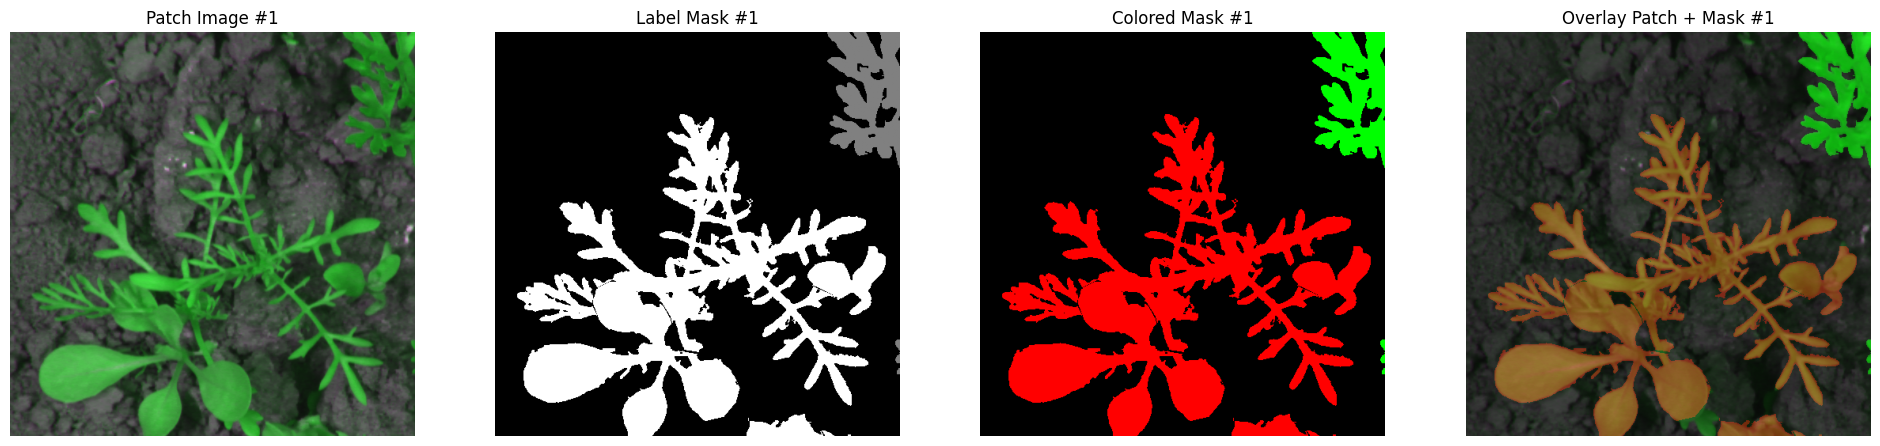

In [14]:
# Dari dataset patch loader (on-the-fly)
import matplotlib.pyplot as plt
visualize_dataset_sample(dataset, index=1)


#Dataset Split

In [15]:
from torch.utils.data import Subset
import numpy as np

import numpy as np
from torch.utils.data import Subset

def split_dataset(dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, shuffle=True):
    # FIX: Handle floating point precision!
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "Total split ratio must be 1.0"

    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    if shuffle:
        np.random.shuffle(indices)

    train_end = int(train_ratio * dataset_size)
    val_end = train_end + int(val_ratio * dataset_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    print(f"Total Patches: {dataset_size}")
    print(f"Train Set  : {len(train_dataset)} patches ({train_ratio*100}%)")
    print(f"Valid Set  : {len(val_dataset)} patches ({val_ratio*100}%)")
    print(f"Test Set   : {len(test_dataset)} patches ({test_ratio*100}%)")

    return train_dataset, val_dataset, test_dataset


#Part 7A: Load Guru Model (Teacher)

##Load Guru Model DeepLabV3+

In [16]:
import segmentation_models_pytorch as smp
import torch

# Setup Guru Model dengan 3 kelas
teacher_model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b4",
    encoder_weights=None,
    classes=3,               # ⚠️ Harus sama kayak training awal guru model
    activation=None
)

# Path ke checkpoint guru lo
checkpoint_path = "/content/drive/MyDrive/colab_indra/ss/cwfid_new/02/best_guru_model.pth"

# Load checkpoint ke guru model
teacher_model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Move ke GPU + freeze guru param
teacher_model.to(device)
teacher_model.eval()

for param in teacher_model.parameters():
    param.requires_grad = False

print("Guru model 3 classes LOADED dan FROZEN ✅")


Guru model 3 classes LOADED dan FROZEN ✅


#Part 7B: Setup Student Model - Fast-SCNN

In [17]:
!git clone https://github.com/Tramac/Fast-SCNN-pytorch.git
%cd Fast-SCNN-pytorch


Cloning into 'Fast-SCNN-pytorch'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 235 (delta 68), reused 65 (delta 65), pack-reused 156 (from 1)
Receiving objects: 100% (235/235), 8.71 MiB | 12.61 MiB/s, done.
Resolving deltas: 100% (121/121), done.
/content/Fast-SCNN-pytorch


In [18]:
# Balik ke folder Fast-SCNN-pytorch repo
%cd /content/Fast-SCNN-pytorch

# Cek isi foldernya
!ls


/content/Fast-SCNN-pytorch
data_loader  eval.py  models  README.md  utils
demo.py      LICENSE  png     train.py	 weights


In [19]:
# Pindah ke repo (kalau belum)
%cd /content/Fast-SCNN-pytorch

# Tambah path repo ke sys.path
import sys
sys.path.append('/content/Fast-SCNN-pytorch')

# Import FastSCNN dari file fast_scnn.py di folder models
from models.fast_scnn import FastSCNN

# Setup student model
student_model = FastSCNN(num_classes=3)
student_model.to(device)

print("Student Model Loaded: Fast-SCNN ✅")



/content/Fast-SCNN-pytorch
Student Model Loaded: Fast-SCNN ✅


In [20]:
!pip install torchinfo

In [21]:
from torchinfo import summary

# Pastikan model di GPU / CPU
student_model = student_model.cuda()  # atau .cpu() sesuai device

# Tampilkan summary, contoh input shape: (batch_size, channels, height, width)
summary(student_model, input_size=(1, 3, 512, 512))


Layer (type:depth-idx)                                  Output Shape              Param #
FastSCNN                                                [1, 3, 512, 512]          --
├─LearningToDownsample: 1-1                             [1, 64, 64, 64]           --
│    └─_ConvBNReLU: 2-1                                 [1, 32, 255, 255]         --
│    │    └─Sequential: 3-1                             [1, 32, 255, 255]         928
│    └─_DSConv: 2-2                                     [1, 48, 128, 128]         --
│    │    └─Sequential: 3-2                             [1, 48, 128, 128]         1,984
│    └─_DSConv: 2-3                                     [1, 64, 64, 64]           --
│    │    └─Sequential: 3-3                             [1, 64, 64, 64]           3,728
├─GlobalFeatureExtractor: 1-2                           [1, 128, 16, 16]          --
│    └─Sequential: 2-4                                  [1, 64, 32, 32]           --
│    │    └─LinearBottleneck: 3-4                    

In [22]:
%cd /content/

/content


#Part 8: Distillation Loss Function (CE + KD Loss)

In [23]:
import torch.nn as nn
import torch.nn.functional as F

# CrossEntropy buat hard label
ce_loss_fn = nn.CrossEntropyLoss()

# Distillation loss function
def distillation_loss(student_outputs, teacher_outputs, labels, alpha=0.5, temperature=4):
    """
    student_outputs: logits dari student model [batch, num_classes, H, W]
    teacher_outputs: logits dari teacher model [batch, num_classes, H, W]
    labels: ground truth [batch, H, W]
    alpha: balancing parameter antara CE loss dan KD loss
    temperature: scaling logits buat KD loss (lebih halus)
    """

    # 1. CrossEntropyLoss biasa
    ce_loss = ce_loss_fn(student_outputs, labels)

    # 2. Soft target distillation (KLDiv loss)
    # Scale logits dengan temperature
    student_soft = F.log_softmax(student_outputs / temperature, dim=1)
    teacher_soft = F.softmax(teacher_outputs / temperature, dim=1)

    kd_loss = F.kl_div(student_soft, teacher_soft, reduction='batchmean') * (temperature ** 2)

    # 3. Total Loss gabungan
    total_loss = alpha * ce_loss + (1 - alpha) * kd_loss

    return total_loss


```
alpha:
0.5 = balance
0.7 = fokus ke ground truth
0.3 = fokus ke output guru
temperature:
4-5 recommended (supaya soft target dari guru lebih smooth buat student)
```



#Part 9: Distillation Training Loop - Vanilla KD

alpha-aware early stopping

In [24]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, freeze_alpha_threshold=0.65):
        self.patience = patience
        self.min_delta = min_delta
        self.freeze_alpha_threshold = freeze_alpha_threshold
        self.counter = 0
        self.best_score = -np.inf
        self.early_stop = False

    def __call__(self, val_iou, epoch):  # <- tambahkan epoch sebagai argumen
        if epoch < self.freeze_epochs:
            return  # Jangan aktifkan early stopping dulu

        if val_iou - self.best_score > self.min_delta:
            self.best_score = val_iou
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np

def calculate_metrics(outputs, masks, num_classes=3):
    """
    outputs: logits dari model, shape (B, C, H, W)
    masks: ground truth label, shape (B, H, W)
    """
    # Ambil prediksi kelas per pixel
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    masks = masks.cpu().numpy()

    iou_list = []
    dice_list = []
    pixel_acc_list = []

    for cls in range(num_classes):
        tp = np.logical_and(preds == cls, masks == cls).sum()
        fp = np.logical_and(preds == cls, masks != cls).sum()
        fn = np.logical_and(preds != cls, masks == cls).sum()

        # IoU
        iou = tp / (tp + fp + fn + 1e-7)
        iou_list.append(iou)

        # Dice
        dice = 2 * tp / (2 * tp + fp + fn + 1e-7)
        dice_list.append(dice)

    # Pixel Accuracy
    pixel_acc = (preds == masks).sum() / np.prod(masks.shape)
    pixel_acc_list.append(pixel_acc)

    return np.mean(iou_list), np.mean(dice_list), np.mean(pixel_acc_list)


In [26]:
# Optimizer buat student model
optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Cek initial learning rate
print(f"Initial Learning Rate: {optimizer.param_groups[0]['lr']}")


Initial Learning Rate: 0.0001


In [27]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',           # maximize val_iou
    factor=0.5,           # Turunin LR jadi setengah
    patience=10,          # Kalau 10 epoch val_iou ga naik, LR diturunin
    threshold=1e-4,       # Toleransi perubahan (agar ga terlalu reaktif)
    min_lr=1e-6,          # Minimum LR biar ga 0
    #verbose=True          # Print info kalau LR turun
)

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_metrics(model, loader, dataset_name='Dataset', num_classes=3, class_names=None):
    model.eval()

    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in loop:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs_raw = model(imgs)

            # Cek output
            outputs = outputs_raw[0] if isinstance(outputs_raw, (tuple, list)) else outputs_raw

            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    # Flatten semua batch jadi 1 array
    all_preds = np.concatenate(all_preds).flatten()
    all_masks = np.concatenate(all_masks).flatten()

    # Hitung metrics
    precision = precision_score(all_masks, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_masks, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_masks, all_preds, average='macro', zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    # Print hasil metrics
    print(f"📊 {dataset_name} Metrics:")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro):    {recall:.4f}")
    print(f"F1-Score (macro):  {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Optional: Plot Confusion Matrix
    if class_names:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{dataset_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    return precision, recall, f1, cm


In [29]:
# Split ke train/val/test
train_dataset, val_dataset, test_dataset = split_dataset(dataset, 0.7, 0.2, 0.1)

# Loader train
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Loader validasi
val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Loader test
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


Total Patches: 480
Train Set  : 336 patches (70.0%)
Valid Set  : 96 patches (20.0%)
Test Set   : 48 patches (10.0%)


In [30]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train_epoch(loader, model, optimizer):
    model.train()
    running_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.cuda()
        masks = masks.cuda()

        optimizer.zero_grad()

        # Mixed Precision Training
        with autocast():
            outputs = model(imgs)

            # Hitung loss → sesuaikan dengan loss yang kamu pakai
            loss = total_loss(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    return running_loss / len(loader)


<ipython-input-30-27281aed4cbc>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
'''
def validate_epoch(loader, model):
    model.eval()
    iou_total, dice_total, acc_total = 0.0, 0.0, 0.0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.cuda()
            masks = masks.cuda()

            with autocast():
                outputs = model(imgs)

            iou, dice, acc = calculate_metrics(outputs, masks)
            iou_total += iou
            dice_total += dice
            acc_total += acc

    num_batches = len(loader)
    return iou_total / num_batches, dice_total / num_batches, acc_total / num_batches
'''

In [31]:
def validate_epoch(loader, model):
    model.eval()

    total_iou = 0.0
    total_dice = 0.0
    total_acc = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            # ================== Forward ==================
            outputs_raw = model(images)
            outputs = outputs_raw[0] if isinstance(outputs_raw, (tuple, list)) else outputs_raw

            # ================== Metrics ==================
            iou, dice, acc = calculate_metrics(outputs, masks)

            total_iou += iou
            total_dice += dice
            total_acc += acc

    avg_iou = total_iou / len(loader)
    avg_dice = total_dice / len(loader)
    avg_acc = total_acc / len(loader)

    return avg_iou, avg_dice, avg_acc


In [32]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets, num_classes=3):
        """
        inputs: logits [B, C, H, W]
        targets: labels [B, H, W]
        """
        # One hot encode target
        targets_one_hot = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2).float()

        # Apply softmax ke input logits → probas
        inputs_soft = F.softmax(inputs, dim=1)

        dims = (0, 2, 3)  # Batch + spatial dims
        intersection = torch.sum(inputs_soft * targets_one_hot, dims)
        cardinality = torch.sum(inputs_soft + targets_one_hot, dims)

        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        dice_loss = 1.0 - dice_score.mean()

        return dice_loss


In [33]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')  # base CE loss

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)  # shape: [batch, H, W]

        pt = torch.exp(-ce_loss)  # prob of correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [34]:
def get_dynamic_alpha(epoch, max_epochs=1000, start_alpha=0.9, end_alpha=0.3, power=0.7):
    progress = epoch / max_epochs
    return round(start_alpha - ((start_alpha - end_alpha) * (progress ** power)), 4)

In [35]:
# Inisialisasi Loss
focal_loss_fn = FocalLoss(alpha=1, gamma=2, reduction='mean')
dice_loss_fn = DiceLoss(smooth=1e-5)

def distillation_loss(student_outputs, teacher_outputs, labels, alpha=0.5, temperature=4, dice_weight=0.5, focal_weight=0.5):
    """
    Dice + Focal Loss (hard label) + KD Loss (soft label)
    """

    # 1. Focal Loss
    focal_loss = focal_loss_fn(student_outputs, labels)

    # 2. Dice Loss
    dice_loss = dice_loss_fn(student_outputs, labels, num_classes=3)

    # 3. Combine Hard Label Loss
    hard_loss = dice_weight * dice_loss + focal_weight * focal_loss

    # 4. KD Loss (soft label distillation)
    student_soft = F.log_softmax(student_outputs / temperature, dim=1)
    teacher_soft = F.softmax(teacher_outputs / temperature, dim=1)
    kd_loss = F.kl_div(student_soft, teacher_soft, reduction='batchmean') * (temperature ** 2)
    kd_loss = kd_loss * 0.001

    # 5. Combine Hard + Soft Loss
    total_loss = alpha * hard_loss + (1 - alpha) * kd_loss
    #print(f"Dice Loss: {dice_loss.item():.4f}, Focal Loss: {focal_loss.item():.4f}, KD Loss: {kd_loss.item():.4f}")

    return total_loss


In [38]:
class EarlyStoppingAlpha:
    def __init__(self, patience=25, min_delta=1e-4, freeze_alpha_threshold=0.65):
        self.patience = patience
        self.min_delta = min_delta
        self.freeze_alpha_threshold = freeze_alpha_threshold
        self.counter = 0
        self.best_score = -float('inf')
        self.early_stop = False

    def __call__(self, val_iou, current_alpha):
        if current_alpha > self.freeze_alpha_threshold:
            return  # Jangan aktifkan early stopping dulu

        if val_iou - self.best_score > self.min_delta:
            self.best_score = val_iou
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [39]:
from tqdm import tqdm
import os
save_path = '/content/drive/MyDrive/colab_indra/ss/cwfid_new/KD03'
# Pastikan foldernya ada
os.makedirs(save_path, exist_ok=True)
# Inisialisasi history buat logging metrics
history = {
    "train_loss": [],
    "val_iou": [],
    "val_dice": [],
    "val_acc": []
}

# Training loop
epochs = 1000
best_val_iou = 0.0
best_val_dice= 0.0
early_stopper = EarlyStoppingAlpha(patience=25, min_delta=1e-4, freeze_alpha_threshold=0.65)

for epoch in range(epochs):
    print(f"\nEpoch [{epoch+1}/{epochs}]")

    # Set student model ke train mode
    student_model.train()
    teacher_model.eval()  # Just in case

    running_loss = 0.0

    # Training loop per batch
    loop = tqdm(train_loader, desc="Training", leave=False)

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # ================== Forward pass ==================
        with torch.no_grad():
            teacher_raw = teacher_model(images)
            teacher_outputs = teacher_raw[0] if isinstance(teacher_raw, (tuple, list)) else teacher_raw

        student_raw = student_model(images)
        student_outputs = student_raw[0] if isinstance(student_raw, (tuple, list)) else student_raw

        # ================== Loss distillation ==================
        dynamic_alpha = get_dynamic_alpha(epoch, max_epochs=epochs, start_alpha=0.7, power=0.7)
        loss = distillation_loss(
            student_outputs, teacher_outputs, labels,
            alpha=dynamic_alpha, temperature=6,
            dice_weight=0.5, focal_weight=0.5
        )


        # Backprop & step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging loss batch
        running_loss += loss.item()

    # Rata-rata loss train epoch ini
    avg_train_loss = running_loss / len(train_loader)

    # ===================== VALIDATION =====================
    val_iou, val_dice, val_acc = validate_epoch(val_loader, student_model)

    # Scheduler step
    scheduler.step(val_iou)

    # Logging learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.8f} | alpha: {dynamic_alpha:.4f}")

    # ===================== HISTORY =====================
    history["train_loss"].append(avg_train_loss)   # Track loss training student per epoch
    history["val_iou"].append(val_iou)             # Validation IoU per epoch
    history["val_dice"].append(val_dice)           # Validation Dice Score per epoch
    history["val_acc"].append(val_acc)             # Validation Pixel Accuracy per epoch
    history.setdefault("lr", []).append(current_lr)  # Learning rate tracking (opsional, bagus ada)
    history.setdefault("alpha", []).append(dynamic_alpha)  # Dynamic alpha log


    # Print progress
    print(f"Train Loss: {avg_train_loss:.4f} | Val IoU: {val_iou:.4f} | Val Dice: {val_dice:.4f} | Val Acc: {val_acc:.4f}")

    # ===================== SAVE BEST =====================
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(student_model.state_dict(), os.path.join(save_path, 'best_student_model_iou.pth'))
        print("✅ Best IoU Model Saved!")

    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(student_model.state_dict(), os.path.join(save_path, 'best_student_model_dice.pth'))
        print("✅ Best Dice Model Saved!")


    # ===================== EARLY STOPPING =====================
    early_stopper(val_iou, current_alpha=dynamic_alpha)


    if early_stopper.early_stop:
        print(f"⏹️ Early stopping triggered at epoch {epoch} with alpha={dynamic_alpha:.4f}")
        break



Epoch [1/1000]


Learning Rate: 0.00010000 | alpha: 0.7000
Train Loss: 1171.5372 | Val IoU: 0.4843 | Val Dice: 0.5485 | Val Acc: 0.9404
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [2/1000]


Learning Rate: 0.00010000 | alpha: 0.6968
Train Loss: 1005.5871 | Val IoU: 0.5123 | Val Dice: 0.5807 | Val Acc: 0.9508
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [3/1000]


Learning Rate: 0.00010000 | alpha: 0.6948
Train Loss: 858.8784 | Val IoU: 0.5052 | Val Dice: 0.5690 | Val Acc: 0.9503

Epoch [4/1000]


Learning Rate: 0.00010000 | alpha: 0.6931
Train Loss: 726.3342 | Val IoU: 0.5245 | Val Dice: 0.5927 | Val Acc: 0.9551
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [5/1000]


Learning Rate: 0.00010000 | alpha: 0.6916
Train Loss: 608.1482 | Val IoU: 0.6073 | Val Dice: 0.7007 | Val Acc: 0.9634
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [6/1000]


Learning Rate: 0.00010000 | alpha: 0.6902
Train Loss: 508.9368 | Val IoU: 0.6584 | Val Dice: 0.7541 | Val Acc: 0.9663
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [7/1000]


Learning Rate: 0.00010000 | alpha: 0.6889
Train Loss: 424.8765 | Val IoU: 0.5895 | Val Dice: 0.6750 | Val Acc: 0.9640

Epoch [8/1000]


Learning Rate: 0.00010000 | alpha: 0.6876
Train Loss: 358.5605 | Val IoU: 0.6148 | Val Dice: 0.7046 | Val Acc: 0.9651

Epoch [9/1000]


Learning Rate: 0.00010000 | alpha: 0.6864
Train Loss: 302.1599 | Val IoU: 0.6527 | Val Dice: 0.7537 | Val Acc: 0.9659

Epoch [10/1000]


Learning Rate: 0.00010000 | alpha: 0.6852
Train Loss: 254.3956 | Val IoU: 0.6805 | Val Dice: 0.7750 | Val Acc: 0.9698
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [11/1000]


Learning Rate: 0.00010000 | alpha: 0.6841
Train Loss: 221.9976 | Val IoU: 0.7014 | Val Dice: 0.7969 | Val Acc: 0.9714
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [12/1000]


Learning Rate: 0.00010000 | alpha: 0.6830
Train Loss: 194.4163 | Val IoU: 0.5842 | Val Dice: 0.6619 | Val Acc: 0.9644

Epoch [13/1000]


Learning Rate: 0.00010000 | alpha: 0.6819
Train Loss: 173.7936 | Val IoU: 0.6871 | Val Dice: 0.7809 | Val Acc: 0.9709

Epoch [14/1000]


Learning Rate: 0.00010000 | alpha: 0.6809
Train Loss: 158.1188 | Val IoU: 0.6072 | Val Dice: 0.7118 | Val Acc: 0.9573

Epoch [15/1000]


Learning Rate: 0.00010000 | alpha: 0.6798
Train Loss: 144.6590 | Val IoU: 0.7314 | Val Dice: 0.8247 | Val Acc: 0.9727
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [16/1000]


Learning Rate: 0.00010000 | alpha: 0.6788
Train Loss: 131.4030 | Val IoU: 0.7171 | Val Dice: 0.8086 | Val Acc: 0.9727

Epoch [17/1000]


Learning Rate: 0.00010000 | alpha: 0.6779
Train Loss: 127.6292 | Val IoU: 0.7261 | Val Dice: 0.8160 | Val Acc: 0.9737

Epoch [18/1000]


Learning Rate: 0.00010000 | alpha: 0.6769
Train Loss: 119.3528 | Val IoU: 0.7215 | Val Dice: 0.8157 | Val Acc: 0.9733

Epoch [19/1000]


Learning Rate: 0.00010000 | alpha: 0.6760
Train Loss: 112.2432 | Val IoU: 0.7060 | Val Dice: 0.7956 | Val Acc: 0.9725

Epoch [20/1000]


Learning Rate: 0.00010000 | alpha: 0.6750
Train Loss: 105.5916 | Val IoU: 0.5580 | Val Dice: 0.6621 | Val Acc: 0.9523

Epoch [21/1000]


Learning Rate: 0.00010000 | alpha: 0.6741
Train Loss: 103.8673 | Val IoU: 0.7502 | Val Dice: 0.8381 | Val Acc: 0.9751
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [22/1000]


Learning Rate: 0.00010000 | alpha: 0.6732
Train Loss: 99.7642 | Val IoU: 0.7429 | Val Dice: 0.8340 | Val Acc: 0.9747

Epoch [23/1000]


Learning Rate: 0.00010000 | alpha: 0.6723
Train Loss: 99.9040 | Val IoU: 0.7397 | Val Dice: 0.8280 | Val Acc: 0.9752

Epoch [24/1000]


Learning Rate: 0.00010000 | alpha: 0.6715
Train Loss: 95.0168 | Val IoU: 0.7296 | Val Dice: 0.8198 | Val Acc: 0.9746

Epoch [25/1000]


Learning Rate: 0.00010000 | alpha: 0.6706
Train Loss: 91.5869 | Val IoU: 0.6357 | Val Dice: 0.7240 | Val Acc: 0.9682

Epoch [26/1000]


Learning Rate: 0.00010000 | alpha: 0.6698
Train Loss: 88.4075 | Val IoU: 0.7345 | Val Dice: 0.8249 | Val Acc: 0.9744

Epoch [27/1000]


Learning Rate: 0.00010000 | alpha: 0.6689
Train Loss: 85.6667 | Val IoU: 0.7726 | Val Dice: 0.8558 | Val Acc: 0.9776
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [28/1000]


Learning Rate: 0.00010000 | alpha: 0.6681
Train Loss: 84.4520 | Val IoU: 0.7362 | Val Dice: 0.8277 | Val Acc: 0.9744

Epoch [29/1000]


Learning Rate: 0.00010000 | alpha: 0.6673
Train Loss: 82.2054 | Val IoU: 0.7772 | Val Dice: 0.8605 | Val Acc: 0.9780
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [30/1000]


Learning Rate: 0.00010000 | alpha: 0.6664
Train Loss: 77.8392 | Val IoU: 0.7569 | Val Dice: 0.8432 | Val Acc: 0.9768

Epoch [31/1000]


Learning Rate: 0.00010000 | alpha: 0.6656
Train Loss: 75.1768 | Val IoU: 0.7842 | Val Dice: 0.8648 | Val Acc: 0.9788
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [32/1000]


Learning Rate: 0.00010000 | alpha: 0.6648
Train Loss: 75.6704 | Val IoU: 0.7770 | Val Dice: 0.8576 | Val Acc: 0.9784

Epoch [33/1000]


Learning Rate: 0.00010000 | alpha: 0.6641
Train Loss: 72.0032 | Val IoU: 0.7850 | Val Dice: 0.8637 | Val Acc: 0.9790
✅ Best IoU Model Saved!

Epoch [34/1000]


Learning Rate: 0.00010000 | alpha: 0.6633
Train Loss: 74.3274 | Val IoU: 0.7830 | Val Dice: 0.8642 | Val Acc: 0.9788

Epoch [35/1000]


Learning Rate: 0.00010000 | alpha: 0.6625
Train Loss: 69.9013 | Val IoU: 0.7782 | Val Dice: 0.8555 | Val Acc: 0.9790

Epoch [36/1000]


Learning Rate: 0.00010000 | alpha: 0.6617
Train Loss: 72.0954 | Val IoU: 0.7871 | Val Dice: 0.8657 | Val Acc: 0.9791
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [37/1000]


Learning Rate: 0.00010000 | alpha: 0.6610
Train Loss: 67.3714 | Val IoU: 0.7790 | Val Dice: 0.8541 | Val Acc: 0.9798

Epoch [38/1000]


Learning Rate: 0.00010000 | alpha: 0.6602
Train Loss: 67.5307 | Val IoU: 0.7943 | Val Dice: 0.8715 | Val Acc: 0.9798
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [39/1000]


Learning Rate: 0.00010000 | alpha: 0.6595
Train Loss: 67.3477 | Val IoU: 0.7794 | Val Dice: 0.8582 | Val Acc: 0.9795

Epoch [40/1000]


Learning Rate: 0.00010000 | alpha: 0.6587
Train Loss: 66.0234 | Val IoU: 0.7761 | Val Dice: 0.8544 | Val Acc: 0.9801

Epoch [41/1000]


Learning Rate: 0.00010000 | alpha: 0.6580
Train Loss: 63.2190 | Val IoU: 0.8021 | Val Dice: 0.8769 | Val Acc: 0.9807
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [42/1000]


Learning Rate: 0.00010000 | alpha: 0.6572
Train Loss: 62.8673 | Val IoU: 0.7919 | Val Dice: 0.8677 | Val Acc: 0.9809

Epoch [43/1000]


Learning Rate: 0.00010000 | alpha: 0.6565
Train Loss: 63.9811 | Val IoU: 0.7625 | Val Dice: 0.8470 | Val Acc: 0.9786

Epoch [44/1000]


Learning Rate: 0.00010000 | alpha: 0.6558
Train Loss: 65.2027 | Val IoU: 0.7977 | Val Dice: 0.8713 | Val Acc: 0.9812

Epoch [45/1000]


Learning Rate: 0.00010000 | alpha: 0.6551
Train Loss: 61.3742 | Val IoU: 0.7960 | Val Dice: 0.8723 | Val Acc: 0.9810

Epoch [46/1000]


Learning Rate: 0.00010000 | alpha: 0.6544
Train Loss: 61.0618 | Val IoU: 0.7932 | Val Dice: 0.8674 | Val Acc: 0.9811

Epoch [47/1000]


Learning Rate: 0.00010000 | alpha: 0.6537
Train Loss: 59.2291 | Val IoU: 0.8012 | Val Dice: 0.8750 | Val Acc: 0.9813

Epoch [48/1000]


Learning Rate: 0.00010000 | alpha: 0.6530
Train Loss: 58.1269 | Val IoU: 0.7964 | Val Dice: 0.8700 | Val Acc: 0.9817

Epoch [49/1000]


Learning Rate: 0.00010000 | alpha: 0.6523
Train Loss: 62.1786 | Val IoU: 0.7992 | Val Dice: 0.8729 | Val Acc: 0.9813

Epoch [50/1000]


Learning Rate: 0.00010000 | alpha: 0.6516
Train Loss: 56.8967 | Val IoU: 0.7884 | Val Dice: 0.8625 | Val Acc: 0.9816

Epoch [51/1000]


Learning Rate: 0.00010000 | alpha: 0.6509
Train Loss: 57.0158 | Val IoU: 0.8011 | Val Dice: 0.8756 | Val Acc: 0.9815

Epoch [52/1000]


Learning Rate: 0.00010000 | alpha: 0.6502
Train Loss: 57.8454 | Val IoU: 0.8046 | Val Dice: 0.8773 | Val Acc: 0.9822
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [53/1000]


Learning Rate: 0.00010000 | alpha: 0.6495
Train Loss: 57.9357 | Val IoU: 0.8104 | Val Dice: 0.8814 | Val Acc: 0.9826
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [54/1000]


Learning Rate: 0.00010000 | alpha: 0.6488
Train Loss: 55.6897 | Val IoU: 0.8143 | Val Dice: 0.8842 | Val Acc: 0.9828
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [55/1000]


Learning Rate: 0.00010000 | alpha: 0.6482
Train Loss: 57.4626 | Val IoU: 0.7981 | Val Dice: 0.8718 | Val Acc: 0.9821

Epoch [56/1000]


Learning Rate: 0.00010000 | alpha: 0.6475
Train Loss: 55.6719 | Val IoU: 0.8112 | Val Dice: 0.8828 | Val Acc: 0.9825

Epoch [57/1000]


Learning Rate: 0.00010000 | alpha: 0.6468
Train Loss: 56.5109 | Val IoU: 0.8031 | Val Dice: 0.8742 | Val Acc: 0.9817

Epoch [58/1000]


Learning Rate: 0.00010000 | alpha: 0.6462
Train Loss: 55.0649 | Val IoU: 0.8073 | Val Dice: 0.8789 | Val Acc: 0.9820

Epoch [59/1000]


Learning Rate: 0.00010000 | alpha: 0.6455
Train Loss: 55.3096 | Val IoU: 0.8049 | Val Dice: 0.8761 | Val Acc: 0.9821

Epoch [60/1000]


Learning Rate: 0.00010000 | alpha: 0.6448
Train Loss: 56.1255 | Val IoU: 0.8018 | Val Dice: 0.8748 | Val Acc: 0.9820

Epoch [61/1000]


Learning Rate: 0.00010000 | alpha: 0.6442
Train Loss: 57.3039 | Val IoU: 0.8082 | Val Dice: 0.8796 | Val Acc: 0.9828

Epoch [62/1000]


Learning Rate: 0.00010000 | alpha: 0.6435
Train Loss: 52.8978 | Val IoU: 0.8017 | Val Dice: 0.8750 | Val Acc: 0.9822

Epoch [63/1000]


Learning Rate: 0.00010000 | alpha: 0.6429
Train Loss: 55.5220 | Val IoU: 0.7953 | Val Dice: 0.8696 | Val Acc: 0.9817

Epoch [64/1000]


Learning Rate: 0.00010000 | alpha: 0.6422
Train Loss: 55.2801 | Val IoU: 0.8102 | Val Dice: 0.8813 | Val Acc: 0.9827

Epoch [65/1000]


Learning Rate: 0.00010000 | alpha: 0.6416
Train Loss: 51.2765 | Val IoU: 0.8210 | Val Dice: 0.8895 | Val Acc: 0.9832
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [66/1000]


Learning Rate: 0.00010000 | alpha: 0.6410
Train Loss: 51.7506 | Val IoU: 0.8117 | Val Dice: 0.8815 | Val Acc: 0.9830

Epoch [67/1000]


Learning Rate: 0.00010000 | alpha: 0.6403
Train Loss: 50.8824 | Val IoU: 0.8038 | Val Dice: 0.8739 | Val Acc: 0.9824

Epoch [68/1000]


Learning Rate: 0.00010000 | alpha: 0.6397
Train Loss: 52.0498 | Val IoU: 0.8240 | Val Dice: 0.8917 | Val Acc: 0.9832
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [69/1000]


Learning Rate: 0.00010000 | alpha: 0.6391
Train Loss: 52.7908 | Val IoU: 0.8080 | Val Dice: 0.8806 | Val Acc: 0.9824

Epoch [70/1000]


Learning Rate: 0.00010000 | alpha: 0.6384
Train Loss: 51.0717 | Val IoU: 0.8191 | Val Dice: 0.8884 | Val Acc: 0.9832

Epoch [71/1000]


Learning Rate: 0.00010000 | alpha: 0.6378
Train Loss: 52.3629 | Val IoU: 0.8169 | Val Dice: 0.8842 | Val Acc: 0.9833

Epoch [72/1000]


Learning Rate: 0.00010000 | alpha: 0.6372
Train Loss: 50.1800 | Val IoU: 0.8190 | Val Dice: 0.8874 | Val Acc: 0.9831

Epoch [73/1000]


Learning Rate: 0.00010000 | alpha: 0.6366
Train Loss: 50.9824 | Val IoU: 0.8213 | Val Dice: 0.8889 | Val Acc: 0.9834

Epoch [74/1000]


Learning Rate: 0.00010000 | alpha: 0.6360
Train Loss: 52.4794 | Val IoU: 0.7969 | Val Dice: 0.8713 | Val Acc: 0.9825

Epoch [75/1000]


Learning Rate: 0.00010000 | alpha: 0.6354
Train Loss: 50.2030 | Val IoU: 0.8225 | Val Dice: 0.8903 | Val Acc: 0.9835

Epoch [76/1000]


Learning Rate: 0.00010000 | alpha: 0.6347
Train Loss: 49.5586 | Val IoU: 0.8126 | Val Dice: 0.8809 | Val Acc: 0.9831

Epoch [77/1000]


Learning Rate: 0.00010000 | alpha: 0.6341
Train Loss: 49.4948 | Val IoU: 0.8302 | Val Dice: 0.8955 | Val Acc: 0.9840
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [78/1000]


Learning Rate: 0.00010000 | alpha: 0.6335
Train Loss: 48.6729 | Val IoU: 0.7907 | Val Dice: 0.8658 | Val Acc: 0.9816

Epoch [79/1000]


Learning Rate: 0.00010000 | alpha: 0.6329
Train Loss: 54.0390 | Val IoU: 0.8246 | Val Dice: 0.8918 | Val Acc: 0.9836

Epoch [80/1000]


Learning Rate: 0.00010000 | alpha: 0.6323
Train Loss: 53.7393 | Val IoU: 0.8081 | Val Dice: 0.8782 | Val Acc: 0.9823

Epoch [81/1000]


Learning Rate: 0.00010000 | alpha: 0.6317
Train Loss: 50.8861 | Val IoU: 0.8290 | Val Dice: 0.8939 | Val Acc: 0.9843

Epoch [82/1000]


Learning Rate: 0.00010000 | alpha: 0.6311
Train Loss: 49.7407 | Val IoU: 0.7827 | Val Dice: 0.8586 | Val Acc: 0.9802

Epoch [83/1000]


Learning Rate: 0.00010000 | alpha: 0.6305
Train Loss: 51.1123 | Val IoU: 0.8227 | Val Dice: 0.8890 | Val Acc: 0.9835

Epoch [84/1000]


Learning Rate: 0.00010000 | alpha: 0.6299
Train Loss: 47.7029 | Val IoU: 0.8234 | Val Dice: 0.8875 | Val Acc: 0.9842

Epoch [85/1000]


Learning Rate: 0.00010000 | alpha: 0.6294
Train Loss: 48.0373 | Val IoU: 0.8093 | Val Dice: 0.8781 | Val Acc: 0.9834

Epoch [86/1000]


Learning Rate: 0.00010000 | alpha: 0.6288
Train Loss: 49.6398 | Val IoU: 0.8138 | Val Dice: 0.8840 | Val Acc: 0.9835

Epoch [87/1000]


Learning Rate: 0.00010000 | alpha: 0.6282
Train Loss: 52.0862 | Val IoU: 0.8116 | Val Dice: 0.8830 | Val Acc: 0.9827

Epoch [88/1000]


Learning Rate: 0.00005000 | alpha: 0.6276
Train Loss: 49.3999 | Val IoU: 0.8179 | Val Dice: 0.8865 | Val Acc: 0.9831

Epoch [89/1000]


Learning Rate: 0.00005000 | alpha: 0.6270
Train Loss: 49.5894 | Val IoU: 0.8198 | Val Dice: 0.8871 | Val Acc: 0.9839

Epoch [90/1000]


Learning Rate: 0.00005000 | alpha: 0.6264
Train Loss: 48.0162 | Val IoU: 0.8201 | Val Dice: 0.8878 | Val Acc: 0.9835

Epoch [91/1000]


Learning Rate: 0.00005000 | alpha: 0.6259
Train Loss: 48.6858 | Val IoU: 0.8312 | Val Dice: 0.8959 | Val Acc: 0.9842
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [92/1000]


Learning Rate: 0.00005000 | alpha: 0.6253
Train Loss: 47.7057 | Val IoU: 0.8205 | Val Dice: 0.8884 | Val Acc: 0.9835

Epoch [93/1000]


Learning Rate: 0.00005000 | alpha: 0.6247
Train Loss: 46.4273 | Val IoU: 0.8271 | Val Dice: 0.8931 | Val Acc: 0.9844

Epoch [94/1000]


Learning Rate: 0.00005000 | alpha: 0.6241
Train Loss: 47.5625 | Val IoU: 0.8249 | Val Dice: 0.8916 | Val Acc: 0.9839

Epoch [95/1000]


Learning Rate: 0.00005000 | alpha: 0.6236
Train Loss: 47.4887 | Val IoU: 0.8329 | Val Dice: 0.8967 | Val Acc: 0.9843
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [96/1000]


Learning Rate: 0.00005000 | alpha: 0.6230
Train Loss: 47.0837 | Val IoU: 0.8272 | Val Dice: 0.8930 | Val Acc: 0.9838

Epoch [97/1000]


Learning Rate: 0.00005000 | alpha: 0.6224
Train Loss: 46.7472 | Val IoU: 0.8375 | Val Dice: 0.9003 | Val Acc: 0.9848
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [98/1000]


Learning Rate: 0.00005000 | alpha: 0.6219
Train Loss: 46.6452 | Val IoU: 0.8215 | Val Dice: 0.8912 | Val Acc: 0.9834

Epoch [99/1000]


Learning Rate: 0.00005000 | alpha: 0.6213
Train Loss: 47.9553 | Val IoU: 0.8220 | Val Dice: 0.8899 | Val Acc: 0.9831

Epoch [100/1000]


Learning Rate: 0.00005000 | alpha: 0.6207
Train Loss: 48.1416 | Val IoU: 0.8266 | Val Dice: 0.8921 | Val Acc: 0.9843

Epoch [101/1000]


Learning Rate: 0.00005000 | alpha: 0.6202
Train Loss: 46.4924 | Val IoU: 0.8275 | Val Dice: 0.8922 | Val Acc: 0.9843

Epoch [102/1000]


Learning Rate: 0.00005000 | alpha: 0.6196
Train Loss: 48.0685 | Val IoU: 0.8429 | Val Dice: 0.9076 | Val Acc: 0.9849
✅ Best IoU Model Saved!
✅ Best Dice Model Saved!

Epoch [103/1000]


Learning Rate: 0.00005000 | alpha: 0.6191
Train Loss: 45.9904 | Val IoU: 0.8271 | Val Dice: 0.8957 | Val Acc: 0.9841

Epoch [104/1000]


Learning Rate: 0.00005000 | alpha: 0.6185
Train Loss: 45.4328 | Val IoU: 0.8325 | Val Dice: 0.9011 | Val Acc: 0.9842

Epoch [105/1000]


Learning Rate: 0.00005000 | alpha: 0.6180
Train Loss: 45.4815 | Val IoU: 0.8350 | Val Dice: 0.8992 | Val Acc: 0.9847

Epoch [106/1000]


Learning Rate: 0.00005000 | alpha: 0.6174
Train Loss: 45.8457 | Val IoU: 0.8349 | Val Dice: 0.9022 | Val Acc: 0.9846

Epoch [107/1000]


Learning Rate: 0.00005000 | alpha: 0.6169
Train Loss: 48.9822 | Val IoU: 0.8218 | Val Dice: 0.8886 | Val Acc: 0.9840

Epoch [108/1000]


Learning Rate: 0.00005000 | alpha: 0.6163
Train Loss: 46.8492 | Val IoU: 0.8284 | Val Dice: 0.8957 | Val Acc: 0.9845

Epoch [109/1000]


Learning Rate: 0.00005000 | alpha: 0.6158
Train Loss: 46.4240 | Val IoU: 0.8150 | Val Dice: 0.8789 | Val Acc: 0.9844

Epoch [110/1000]


Learning Rate: 0.00005000 | alpha: 0.6152
Train Loss: 46.3171 | Val IoU: 0.8252 | Val Dice: 0.8925 | Val Acc: 0.9843

Epoch [111/1000]


Learning Rate: 0.00005000 | alpha: 0.6147
Train Loss: 45.8455 | Val IoU: 0.8270 | Val Dice: 0.8938 | Val Acc: 0.9843

Epoch [112/1000]


Learning Rate: 0.00005000 | alpha: 0.6141
Train Loss: 46.0634 | Val IoU: 0.8274 | Val Dice: 0.8968 | Val Acc: 0.9837

Epoch [113/1000]


Learning Rate: 0.00002500 | alpha: 0.6136
Train Loss: 46.5734 | Val IoU: 0.8236 | Val Dice: 0.8888 | Val Acc: 0.9841

Epoch [114/1000]


Learning Rate: 0.00002500 | alpha: 0.6131
Train Loss: 46.5953 | Val IoU: 0.8223 | Val Dice: 0.8904 | Val Acc: 0.9839

Epoch [115/1000]


Learning Rate: 0.00002500 | alpha: 0.6125
Train Loss: 46.1485 | Val IoU: 0.8270 | Val Dice: 0.8978 | Val Acc: 0.9839

Epoch [116/1000]


Learning Rate: 0.00002500 | alpha: 0.6120
Train Loss: 45.7642 | Val IoU: 0.8387 | Val Dice: 0.9054 | Val Acc: 0.9849

Epoch [117/1000]


Learning Rate: 0.00002500 | alpha: 0.6115
Train Loss: 46.3657 | Val IoU: 0.8320 | Val Dice: 0.8963 | Val Acc: 0.9845

Epoch [118/1000]


Learning Rate: 0.00002500 | alpha: 0.6109
Train Loss: 45.4449 | Val IoU: 0.8385 | Val Dice: 0.9049 | Val Acc: 0.9848

Epoch [119/1000]


Learning Rate: 0.00002500 | alpha: 0.6104
Train Loss: 45.5854 | Val IoU: 0.8299 | Val Dice: 0.8954 | Val Acc: 0.9849

Epoch [120/1000]


Learning Rate: 0.00002500 | alpha: 0.6099
Train Loss: 46.5645 | Val IoU: 0.8364 | Val Dice: 0.9022 | Val Acc: 0.9849

Epoch [121/1000]


Learning Rate: 0.00002500 | alpha: 0.6093
Train Loss: 45.4628 | Val IoU: 0.8324 | Val Dice: 0.8990 | Val Acc: 0.9849

Epoch [122/1000]


Learning Rate: 0.00002500 | alpha: 0.6088
Train Loss: 44.9848 | Val IoU: 0.8315 | Val Dice: 0.8984 | Val Acc: 0.9849

Epoch [123/1000]


Learning Rate: 0.00002500 | alpha: 0.6083
Train Loss: 46.2511 | Val IoU: 0.8298 | Val Dice: 0.8973 | Val Acc: 0.9843

Epoch [124/1000]


Learning Rate: 0.00001250 | alpha: 0.6077
Train Loss: 45.1127 | Val IoU: 0.8328 | Val Dice: 0.9012 | Val Acc: 0.9842

Epoch [125/1000]


Learning Rate: 0.00001250 | alpha: 0.6072
Train Loss: 46.1545 | Val IoU: 0.8328 | Val Dice: 0.8995 | Val Acc: 0.9848

Epoch [126/1000]


Learning Rate: 0.00001250 | alpha: 0.6067
Train Loss: 45.1977 | Val IoU: 0.8367 | Val Dice: 0.8998 | Val Acc: 0.9851

Epoch [127/1000]


Learning Rate: 0.00001250 | alpha: 0.6062
Train Loss: 45.9526 | Val IoU: 0.8388 | Val Dice: 0.9058 | Val Acc: 0.9846
⏹️ Early stopping triggered at epoch 126 with alpha=0.6062


In [40]:
import os
save_path = '/content/drive/MyDrive/colab_indra/ss/cwfid_new/KD03'

os.makedirs(save_path, exist_ok=True)
# Path file
best_model_path = os.path.join(save_path, 'best_student_model.pth')

# Save best model guru
torch.save(student_model.state_dict(), best_model_path)
print(f"✅ Model Murid Terbaik Disimpan di: {best_model_path}")

✅ Model Guru Terbaik Disimpan di: /content/drive/MyDrive/colab_indra/ss/cwfid_new/KD03/best_student_model.pth


## Simpan History

In [41]:
import os
import json
import pandas as pd

# Path penyimpanan di Google Drive
save_path = '/content/drive/MyDrive/colab_indra/ss/cwfid_new/KD03'

# Pastikan folder ada
os.makedirs(save_path, exist_ok=True)

# Save JSON
history_filename_json = os.path.join(save_path, 'student_training_history.json')
with open(history_filename_json, 'w') as f:
    json.dump(history, f)
print(f"✅ History JSON saved to {history_filename_json}")

# Save CSV
df_history = pd.DataFrame(history)
history_filename_csv = os.path.join(save_path, 'student_history.csv')
df_history.to_csv(history_filename_csv, index=False)
print(f"✅ History CSV saved to {history_filename_csv}")



✅ History JSON saved to /content/drive/MyDrive/colab_indra/ss/cwfid_new/KD03/student_training_history.json
✅ History CSV saved to /content/drive/MyDrive/colab_indra/ss/cwfid_new/KD03/student_history.csv


#Plot Training History (Loss, IoU, Dice, Acc)

In [42]:
import matplotlib.pyplot as plt

def plot_student_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(18, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot Val Metrics (IoU, Dice, Acc)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_iou'], 'g-', label='Val IoU')
    plt.plot(epochs, history['val_dice'], 'r-', label='Val Dice')
    plt.plot(epochs, history['val_acc'], 'b-', label='Val Acc')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()

    plt.show()


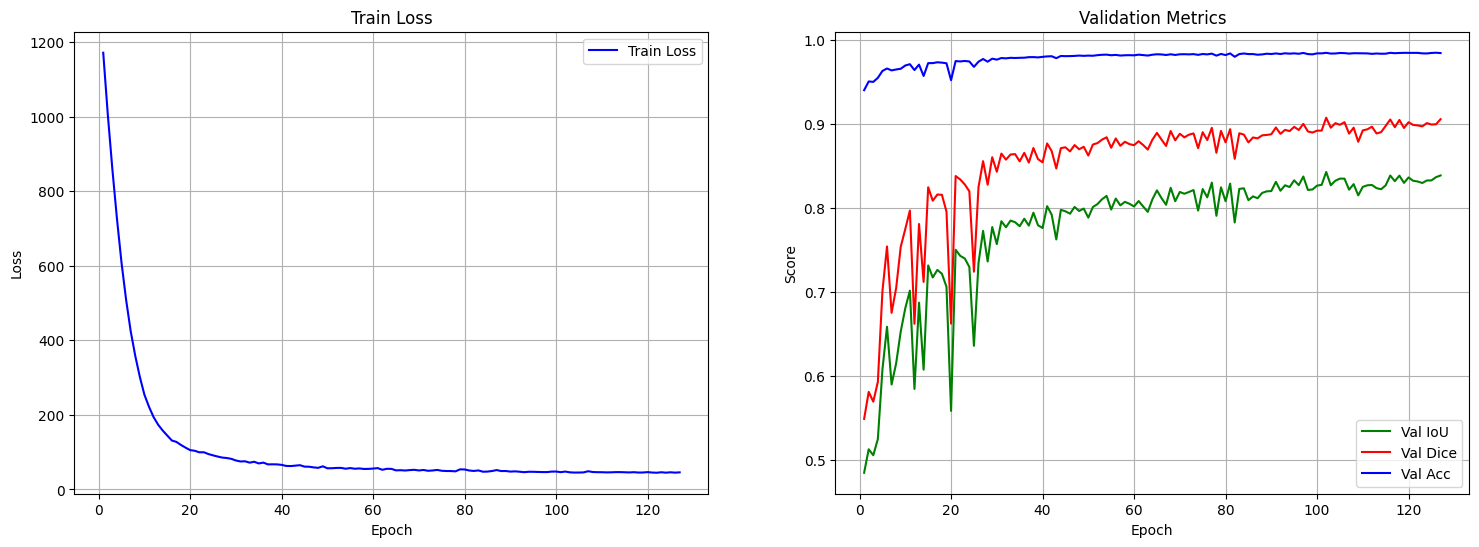

In [43]:
# Panggil setelah training loop selesai
plot_student_history(history)


In [44]:
def plot_student_history_with_alpha(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(18, 8))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.legend()
    plt.grid(True)

    # Plot Metrics + Alpha
    plt.subplot(2, 1, 2)
    plt.plot(epochs, history['val_iou'], 'g-', label='Val IoU')
    plt.plot(epochs, history['val_dice'], 'r-', label='Val Dice')
    plt.plot(epochs, history['alpha'], 'k--', label='Dynamic Alpha')
    plt.legend()
    plt.grid(True)

    plt.show()


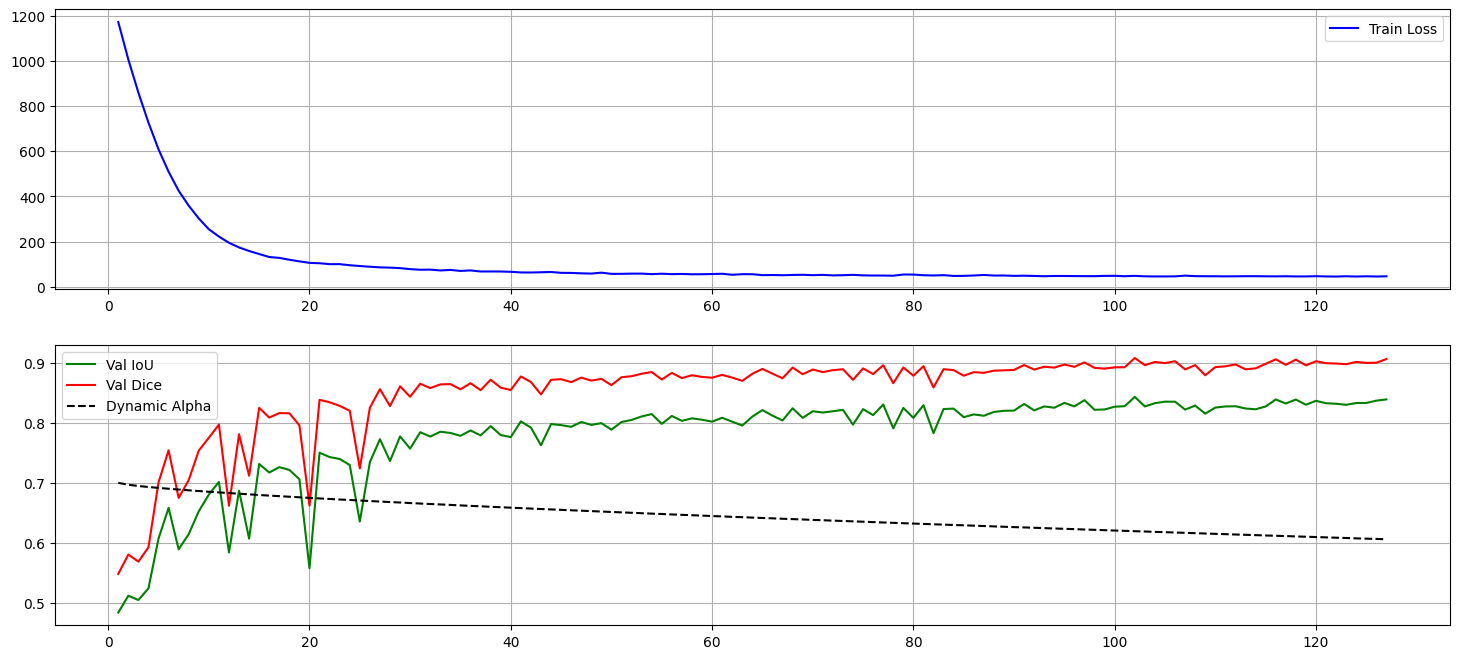

In [45]:
plot_student_history_with_alpha(history)

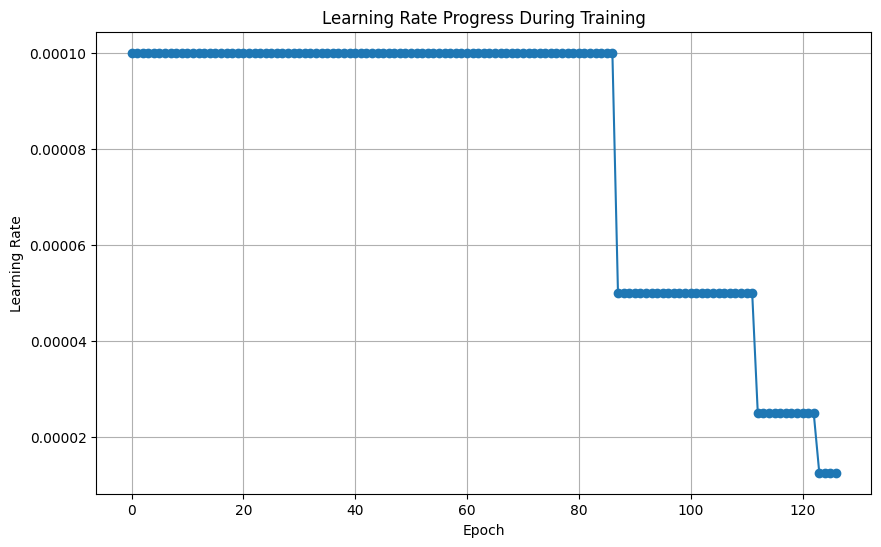

In [46]:
import matplotlib.pyplot as plt

# Plot Learning Rate vs Epoch
plt.figure(figsize=(10, 6))
plt.plot(history["lr"], marker='o')
plt.title("Learning Rate Progress During Training")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


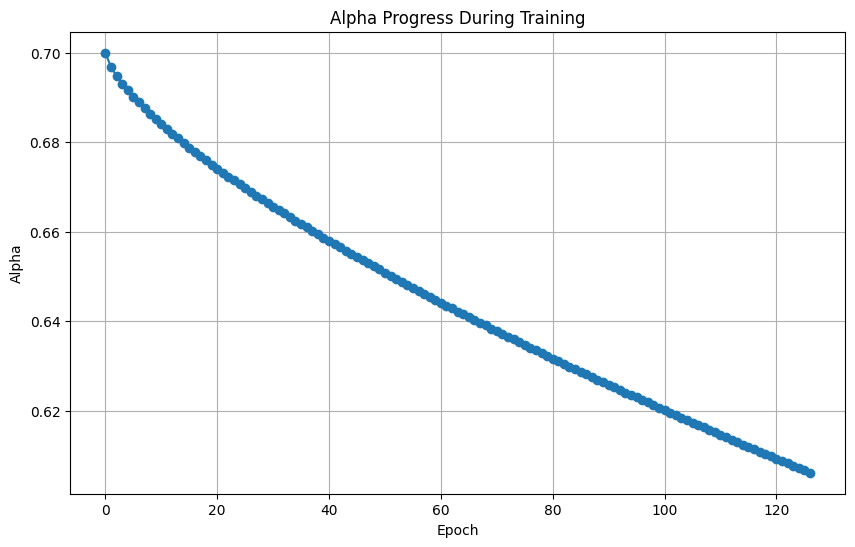

In [47]:
# Plot alpha vs Epoch
plt.figure(figsize=(10, 6))
plt.plot(history["alpha"], marker='o')
plt.title("Alpha Progress During Training")
plt.xlabel("Epoch")
plt.ylabel("Alpha")
plt.grid(True)
plt.show()


#Evaluate_all_metrics

In [49]:
def evaluate_all_metrics(model, loader, class_names=None, num_classes=3, dataset_name="Dataset", device='cuda'):
    model.eval()
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs_raw = model(imgs)
            outputs = outputs_raw[0] if isinstance(outputs_raw, (tuple, list)) else outputs_raw
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    all_preds = np.concatenate(all_preds).flatten()
    all_masks = np.concatenate(all_masks).flatten()

    precision_macro = precision_score(all_masks, all_preds, average='macro', zero_division=0)
    recall_macro = recall_score(all_masks, all_preds, average='macro', zero_division=0)
    f1_macro = f1_score(all_masks, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    precision = precision_score(all_masks, all_preds, average=None, zero_division=0)
    recall = recall_score(all_masks, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_masks, all_preds, average=None, zero_division=0)

    ious = []
    for cls in range(num_classes):
        tp = np.logical_and(all_preds == cls, all_masks == cls).sum()
        fp = np.logical_and(all_preds == cls, all_masks != cls).sum()
        fn = np.logical_and(all_preds != cls, all_masks == cls).sum()
        iou = tp / (tp + fp + fn + 1e-7)
        ious.append(iou)

    pixel_acc = (all_preds == all_masks).sum() / len(all_masks)

    print(f"\n📊 {dataset_name} Evaluation Summary")
    print(f"Overall Accuracy: {pixel_acc:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Recall (macro):    {recall_macro:.4f}")
    print(f"F1-Score (macro):  {f1_macro:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    for i in range(num_classes):
        cname = class_names[i] if class_names else f"Class {i}"
        print(f"\n📌 {cname}")
        print(f"  IoU      : {ious[i]:.4f}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall   : {recall[i]:.4f}")
        print(f"  F1-Score : {f1[i]:.4f}")

    return {
        "overall_accuracy": pixel_acc,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "confusion_matrix": cm,
        "per_class": {
            "iou": ious,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }
    }


#evaluate_all_metrics lengkap

In [57]:
def evaluate_all_metrics(model, loader, class_names=None, num_classes=3, dataset_name="Dataset", device='cuda'):
    import numpy as np
    import torch
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

    model.eval()
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs_raw = model(imgs)
            outputs = outputs_raw[0] if isinstance(outputs_raw, (tuple, list)) else outputs_raw
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    all_preds = np.concatenate(all_preds).flatten()
    all_masks = np.concatenate(all_masks).flatten()

    # Macro average
    precision_macro = precision_score(all_masks, all_preds, average='macro', zero_division=0)
    recall_macro = recall_score(all_masks, all_preds, average='macro', zero_division=0)
    f1_macro = f1_score(all_masks, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    # Per-class metrics
    precision = precision_score(all_masks, all_preds, average=None, zero_division=0)
    recall = recall_score(all_masks, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_masks, all_preds, average=None, zero_division=0)

    # IoU and Dice per class
    ious = []
    dices = []
    for cls in range(num_classes):
        tp = np.logical_and(all_preds == cls, all_masks == cls).sum()
        fp = np.logical_and(all_preds == cls, all_masks != cls).sum()
        fn = np.logical_and(all_preds != cls, all_masks == cls).sum()

        iou = tp / (tp + fp + fn + 1e-7)
        dice = 2 * tp / (2 * tp + fp + fn + 1e-7)

        ious.append(iou)
        dices.append(dice)

    pixel_acc = (all_preds == all_masks).sum() / len(all_masks)
    miou = np.mean(ious)
    mdice = np.mean(dices)

    print(f"\n📊 {dataset_name} Evaluation Summary")
    print(f"Overall Accuracy : {pixel_acc:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Recall (macro)   : {recall_macro:.4f}")
    print(f"F1-Score (macro) : {f1_macro:.4f}")
    print(f"mIoU             : {miou:.4f}")
    print(f"mDice            : {mdice:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    for i in range(num_classes):
        cname = class_names[i] if class_names else f"Class {i}"
        print(f"\n📌 {cname}")
        print(f"  IoU      : {ious[i]:.4f}")
        print(f"  Dice     : {dices[i]:.4f}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall   : {recall[i]:.4f}")
        print(f"  F1-Score : {f1[i]:.4f}")

    return {
        "overall_accuracy": pixel_acc,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "miou": miou,
        "mdice": mdice,
        "confusion_matrix": cm,
        "per_class": {
            "iou": ious,
            "dice": dices,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }
    }


In [63]:
# Load model terbaik
student_model.load_state_dict(torch.load('/content/drive/MyDrive/colab_indra/ss/cwfid_new/KD03/best_student_model.pth'))

# Evaluasi test set
evaluate_all_metrics(student_model, test_loader, class_names=["BG", "Crop", "Weed"], dataset_name="Test Set", device=device)



📊 Test Set Evaluation Summary
Overall Accuracy : 0.9850
Precision (macro): 0.9403
Recall (macro)   : 0.9300
F1-Score (macro) : 0.9351
mIoU             : 0.8813
mDice            : 0.9351
Confusion Matrix:
[[11267406    20776    53385]
 [   29177   273341     8396]
 [   66265    10639   853527]]

📌 BG
  IoU      : 0.9852
  Dice     : 0.9925
  Precision: 0.9916
  Recall   : 0.9935
  F1-Score : 0.9925

📌 Crop
  IoU      : 0.7985
  Dice     : 0.8879
  Precision: 0.8969
  Recall   : 0.8792
  F1-Score : 0.8879

📌 Weed
  IoU      : 0.8602
  Dice     : 0.9249
  Precision: 0.9325
  Recall   : 0.9173
  F1-Score : 0.9249


{'overall_accuracy': np.float64(0.9850083986918131),
 'precision_macro': 0.9403401857316865,
 'recall_macro': 0.9299866809134073,
 'f1_macro': 0.9351128313730719,
 'miou': np.float64(0.8812905654011094),
 'mdice': np.float64(0.9351128313730057),
 'confusion_matrix': array([[11267406,    20776,    53385],
        [   29177,   273341,     8396],
        [   66265,    10639,   853527]]),
 'per_class': {'iou': [np.float64(0.9851706857973007),
   np.float64(0.7984745668638069),
   np.float64(0.8602264435422208)],
  'dice': [np.float64(0.9925299550770148),
   np.float64(0.8879464648267923),
   np.float64(0.92486207421521)],
  'precision': array([0.99160052, 0.89691753, 0.9325025 ]),
  'recall': array([0.99346113, 0.87915308, 0.91734583]),
  'f1': array([0.99252996, 0.88794646, 0.92486207])}}

# Fungsi Evaluasi Klasik

📊 Training Metrics:
Precision (macro): 0.9512
Recall (macro):    0.9409
F1-Score (macro):  0.9460
Confusion Matrix:
[[79936625   120526   311616]
 [  165630  1657301     8668]
 [  420863    30501  5428654]]


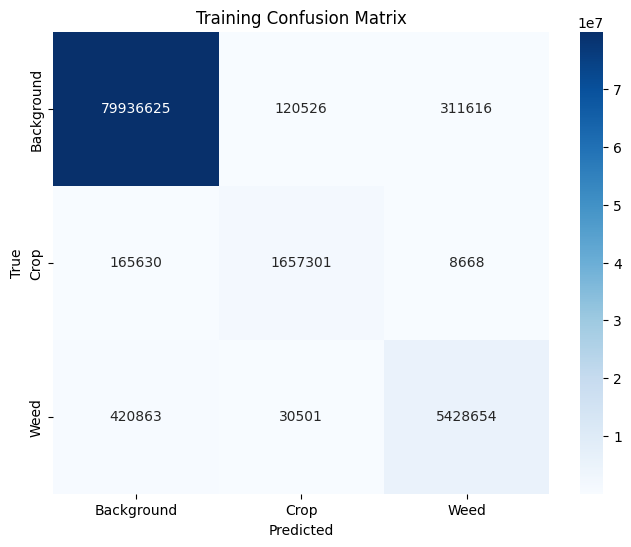

📊 Validation Metrics:
Precision (macro): 0.9534
Recall (macro):    0.9390
F1-Score (macro):  0.9461
Confusion Matrix:
[[79949133   108659   310975]
 [  171708  1648468    11423]
 [  429528    27491  5422999]]


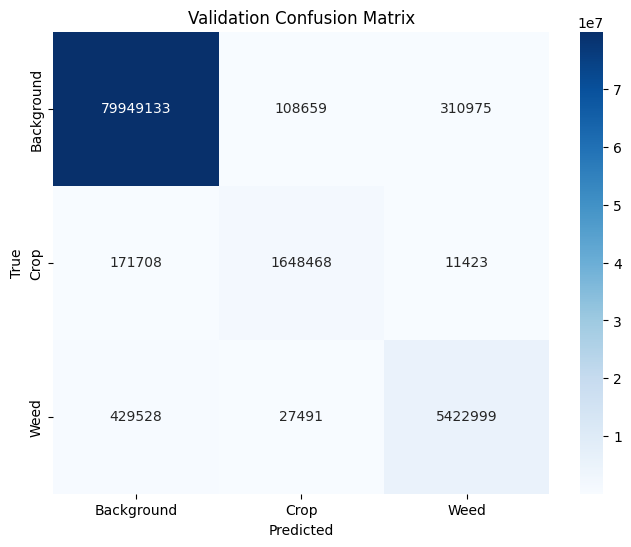

📊 Test Metrics:
Precision (macro): 0.9523
Recall (macro):    0.9432
F1-Score (macro):  0.9477
Confusion Matrix:
[[79938329   115731   314707]
 [  158869  1665433     7297]
 [  406682    29710  5443626]]


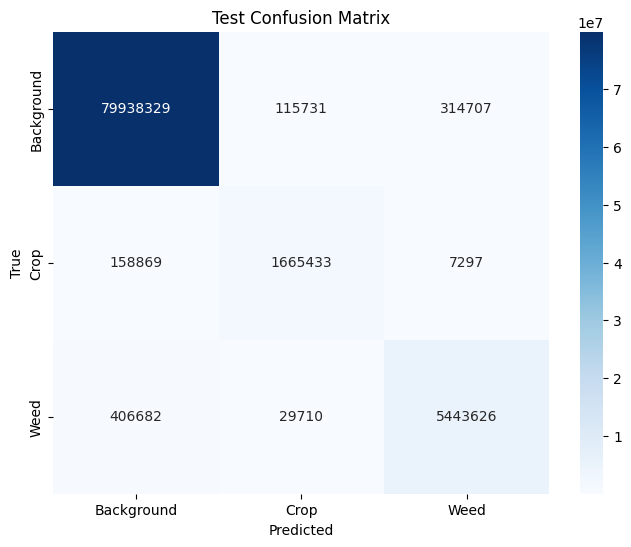

In [51]:
calculate_metrics
# Load model guru terbaik
#model.load_state_dict(torch.load('best_guru_model.pth'))
student_model.cuda()

# Nama kelas (optional buat plot)
class_names = ['Background', 'Crop', 'Weed']

# Evaluasi di training data
train_precision, train_recall, train_f1, train_cm = evaluate_metrics(
    student_model, train_loader, dataset_name='Training', class_names=class_names
)

# Evaluasi di validation data
val_precision, val_recall, val_f1, val_cm = evaluate_metrics(
    student_model, val_loader, dataset_name='Validation', class_names=class_names
)

# Evaluasi di test data
test_precision, test_recall, test_f1, test_cm = evaluate_metrics(
    student_model, test_loader,
    dataset_name='Test',
    class_names=class_names
)

📊 Training Metrics:
Precision (macro): 0.9522
Recall (macro):    0.9397
F1-Score (macro):  0.9459
Confusion Matrix:
[[79945456   112719   310592]
 [  172365  1650223     9011]
 [  418873    31423  5429722]]


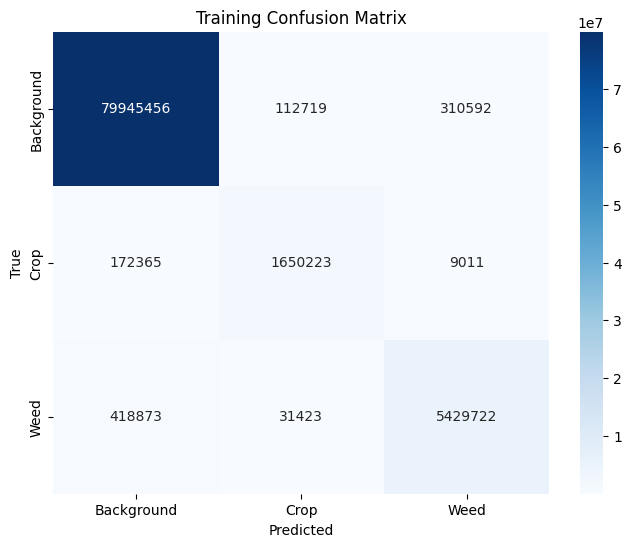

📊 Validation Metrics:
Precision (macro): 0.9516
Recall (macro):    0.9409
F1-Score (macro):  0.9462
Confusion Matrix:
[[79934213   114333   320221]
 [  170189  1651276    10134]
 [  400833    31160  5448025]]


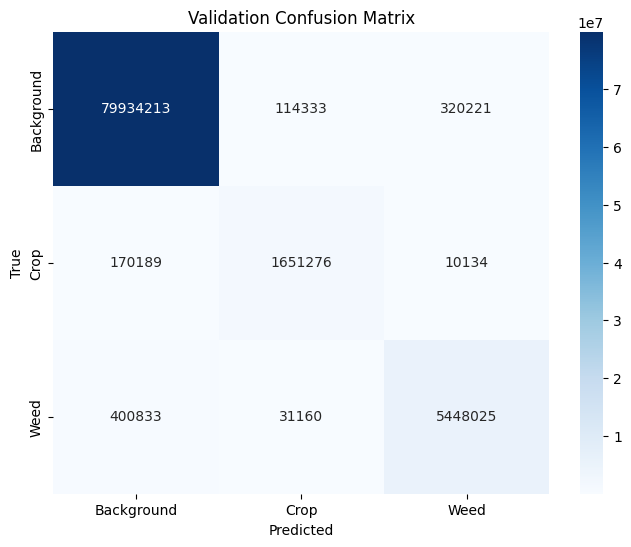

📊 Test Metrics:
Precision (macro): 0.9523
Recall (macro):    0.9397
F1-Score (macro):  0.9459
Confusion Matrix:
[[79943671   112064   313032]
 [  172337  1649847     9415]
 [  417456    30964  5431598]]


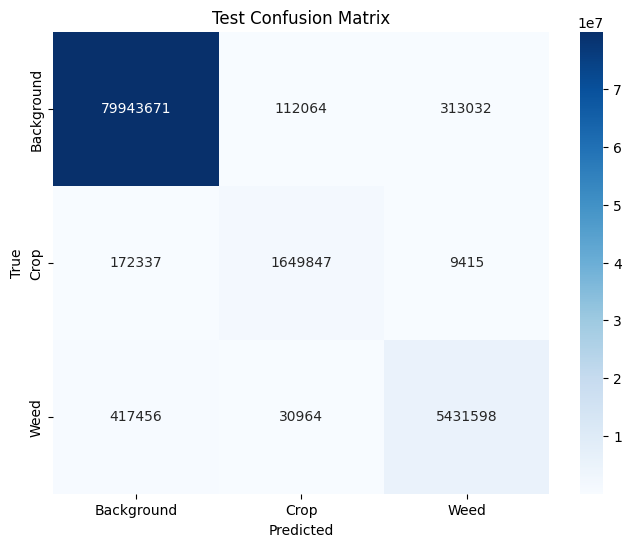

In [52]:
# Load model guru terbaik
#model.load_state_dict(torch.load('best_guru_model.pth'))
student_model.cuda()

# Nama kelas (optional buat plot)
class_names = ['Background', 'Crop', 'Weed']

# Evaluasi di training data
train_precision, train_recall, train_f1, train_cm = evaluate_metrics(
    student_model, train_loader, dataset_name='Training', class_names=class_names
)

# Evaluasi di validation data
val_precision, val_recall, val_f1, val_cm = evaluate_metrics(
    student_model, val_loader, dataset_name='Validation', class_names=class_names
)

# Evaluasi di test data
test_precision, test_recall, test_f1, test_cm = evaluate_metrics(
    student_model, test_loader,
    dataset_name='Test',
    class_names=class_names
)


#Evaluasi Per Class

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_per_class_metrics(model, loader, class_names=None, num_classes=3):
    model.eval()

    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in loop:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs_raw = model(imgs)

            # Cek output
            outputs = outputs_raw[0] if isinstance(outputs_raw, (tuple, list)) else outputs_raw

            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy().flatten())
            all_masks.append(masks.cpu().numpy().flatten())

    # Gabungkan semua batch
    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)

    # Confusion Matrix (raw count)
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    # Confusion Matrix (percent per row/class)
    cm_percent = cm.astype(np.float64)
    cm_percent = cm_percent / cm_percent.sum(axis=1, keepdims=True) * 100
    cm_percent = np.round(cm_percent, 2)

    # Precision, Recall, F1-score per kelas
    precision = precision_score(all_masks, all_preds, labels=list(range(num_classes)), average=None, zero_division=0)
    recall = recall_score(all_masks, all_preds, labels=list(range(num_classes)), average=None, zero_division=0)
    f1 = f1_score(all_masks, all_preds, labels=list(range(num_classes)), average=None, zero_division=0)

    # IoU per kelas
    iou_per_class = []
    for cls in range(num_classes):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-7)
        iou_per_class.append(iou)

    # Print Metrics Per Class
    print("Class-wise Metrics:\n")
    for cls in range(num_classes):
        class_name = class_names[cls] if class_names else f"Class {cls}"
        print(f"📌 {class_name}")
        print(f"Precision: {precision[cls]:.4f}")
        print(f"Recall   : {recall[cls]:.4f}")
        print(f"F1-Score : {f1[cls]:.4f}")
        print(f"IoU      : {iou_per_class[cls]:.4f}\n")

    # Plot Confusion Matrix (Percent)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names if class_names else range(num_classes),
                yticklabels=class_names if class_names else range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (%) per Class')
    plt.show()

    return precision, recall, f1, iou_per_class, cm_percent


Class-wise Metrics:

📌 Background
Precision: 0.9925
Recall   : 0.9947
F1-Score : 0.9936
IoU      : 0.9872

📌 Crop
Precision: 0.9201
Recall   : 0.8903
F1-Score : 0.9050
IoU      : 0.8264

📌 Weed
Precision: 0.9423
Recall   : 0.9235
F1-Score : 0.9328
IoU      : 0.8740



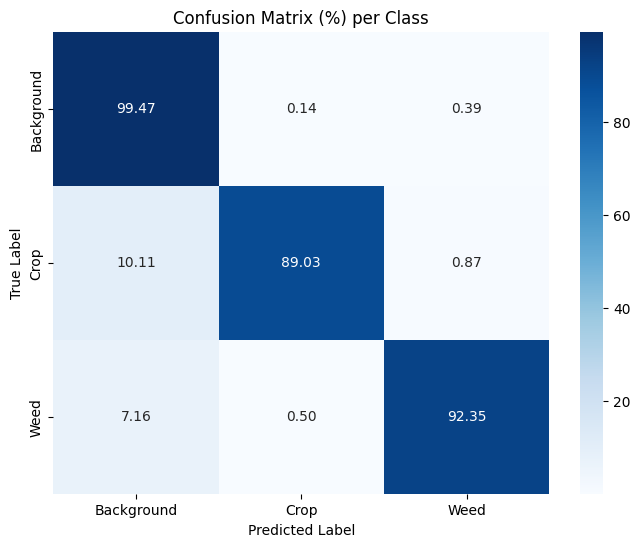

Class-wise Metrics:

📌 Background
Precision: 0.9929
Recall   : 0.9946
F1-Score : 0.9938
IoU      : 0.9876

📌 Crop
Precision: 0.9177
Recall   : 0.9075
F1-Score : 0.9126
IoU      : 0.8392

📌 Weed
Precision: 0.9437
Recall   : 0.9259
F1-Score : 0.9347
IoU      : 0.8774



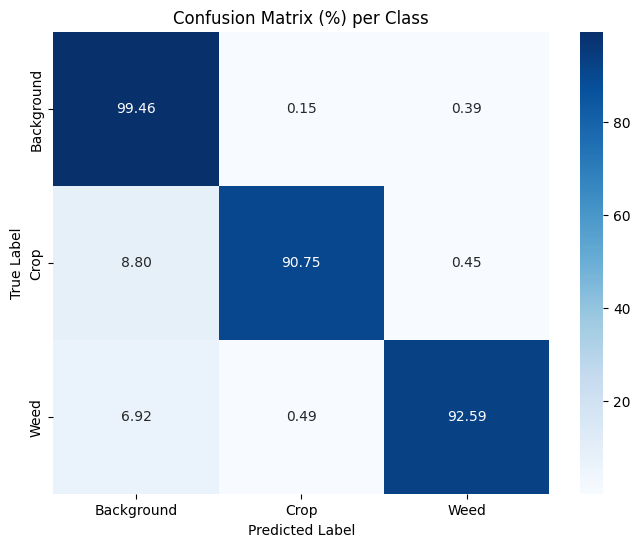

Class-wise Metrics:

📌 Background
Precision: 0.9927
Recall   : 0.9946
F1-Score : 0.9937
IoU      : 0.9874

📌 Crop
Precision: 0.9178
Recall   : 0.9035
F1-Score : 0.9106
IoU      : 0.8359

📌 Weed
Precision: 0.9441
Recall   : 0.9239
F1-Score : 0.9339
IoU      : 0.8760



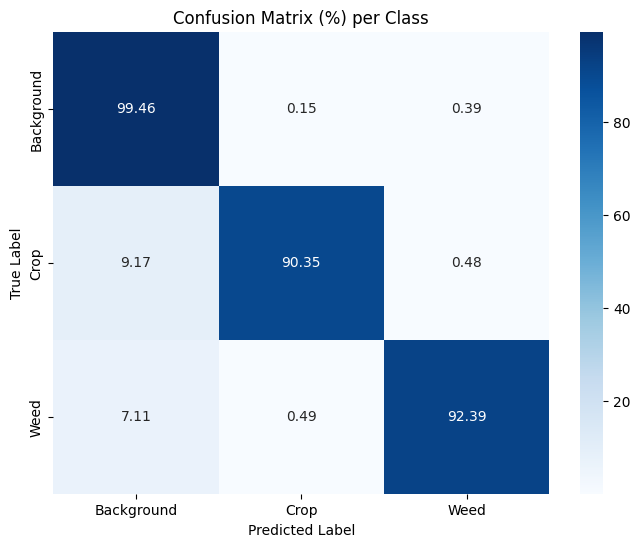

(array([0.99272092, 0.91777621, 0.94411914]),
 array([0.99462493, 0.903516  , 0.9239385 ]),
 array([0.99367201, 0.91059028, 0.93391982]),
 [np.float64(0.9874236025243672),
  np.float64(0.8358565757174328),
  np.float64(0.8760314920000021)],
 array([[99.46,  0.15,  0.39],
        [ 9.17, 90.35,  0.48],
        [ 7.11,  0.49, 92.39]]))

In [66]:
class_names = ['Background', 'Crop', 'Weed']
evaluate_per_class_metrics(student_model, train_loader, class_names=class_names)
evaluate_per_class_metrics(student_model, val_loader, class_names=class_names)
evaluate_per_class_metrics(student_model, test_loader, class_names=class_names)


#Inferensi Full Image Dataset Asli

'''
Load best guru model
model.load_state_dict(torch.load('/content/drive/MyDrive/colab_indra/ss/cwfid_new/02/best_guru_model.pth'))
model.cuda()
model.eval()
'''


In [67]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


In [68]:
def infer_full_image(image_path, model, patch_size=512, stride=256, num_classes=3):
    # Load image asli
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    # Preprocessing sesuai train_transform Normalize (tanpa augmentasi)
    img_norm = (img_np / 255.0 - 0.5) / 0.5
    img_norm = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).float().cuda()  # B, C, H, W

    _, _, H, W = img_norm.shape

    # Prepare empty prediction mask
    pred_mask = torch.zeros((num_classes, H, W)).cuda()
    count_mask = torch.zeros((1, H, W)).cuda()

    # Hitung step posisi y dan x termasuk bagian border
    y_steps = list(range(0, H - patch_size + 1, stride))
    x_steps = list(range(0, W - patch_size + 1, stride))

    # Tambahin patch terakhir buat cover pinggir, kalau belum ke-cover
    if y_steps[-1] + patch_size < H:
        y_steps.append(H - patch_size)
    if x_steps[-1] + patch_size < W:
        x_steps.append(W - patch_size)

    # Sliding window inference (patching)
    for y in y_steps:
        for x in x_steps:
            patch = img_norm[:, :, y:y+patch_size, x:x+patch_size]

            with torch.amp.autocast('cuda'):
                output_raw = model(patch)

                # Unpack output utama kalo return tuple/list
                output = output_raw[0] if isinstance(output_raw, (tuple, list)) else output_raw

            pred_mask[:, y:y+patch_size, x:x+patch_size] += output.squeeze(0)
            count_mask[:, y:y+patch_size, x:x+patch_size] += 1

    # Normalisasi hasil prediksi
    pred_mask /= count_mask
    final_pred = torch.argmax(pred_mask, dim=0).cpu().numpy()

    return img_np, final_pred


In [69]:
def evaluate_single_image(pred_mask, gt_mask, num_classes=3, class_names=None):
    # Flatten mask untuk perhitungan metric
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    # Confusion Matrix
    cm = confusion_matrix(gt_flat, pred_flat, labels=list(range(num_classes)))

    # Precision, Recall, F1-score per kelas
    precision = precision_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)
    recall = recall_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)
    f1 = f1_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)

    # IoU per kelas
    iou_per_class = []
    for cls in range(num_classes):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-7)
        iou_per_class.append(iou)

    # Tampilkan metrik
    print("📊 Per-Class Evaluation Metrics:")
    for cls in range(num_classes):
        name = class_names[cls] if class_names else f"Class {cls}"
        print(f"{name} | Precision: {precision[cls]:.4f}, Recall: {recall[cls]:.4f}, F1: {f1[cls]:.4f}, IoU: {iou_per_class[cls]:.4f}")

    return precision, recall, f1, iou_per_class, cm


In [70]:
def visualize_full_prediction(img_np, pred_mask, gt_mask=None, class_colors=None, alpha=0.4, class_names=None):
    H, W, _ = img_np.shape

    if class_colors is None:
        class_colors = {
            0: [0, 0, 0],        # Background → Black
            1: [0, 255, 0],      # Crop → Green
            2: [255, 0, 0]       # Weed → Red
        }

    # Buat color mask dari prediksi
    color_pred_mask = np.zeros((H, W, 3), dtype=np.uint8)
    for cls, color in class_colors.items():
        color_pred_mask[pred_mask == cls] = color

    # Overlay prediksi di gambar asli
    overlay_pred = (1 - alpha) * img_np / 255.0 + alpha * color_pred_mask / 255.0
    overlay_pred = np.clip(overlay_pred, 0, 1)

    # Buat color mask dari ground truth (jika ada)
    if gt_mask is not None:
        color_gt_mask = np.zeros((H, W, 3), dtype=np.uint8)
        for cls, color in class_colors.items():
            color_gt_mask[gt_mask == cls] = color
    else:
        color_gt_mask = np.zeros((H, W, 3), dtype=np.uint8)

    # Plot visualisasi
    plt.figure(figsize=(24, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(color_gt_mask)
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(color_pred_mask)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay_pred)
    plt.title("Overlay Prediction")
    plt.axis('off')

    plt.show()

    # ✅ Evaluasi metrik setelah visualisasi
    if gt_mask is not None:
        precision, recall, f1, iou_per_class, cm = evaluate_single_image(pred_mask, gt_mask, num_classes=len(class_colors), class_names=class_names)
        return precision, recall, f1, iou_per_class, cm
    else:
        print("⚠️ Ground truth mask not provided, skipping metrics evaluation.")
        return None


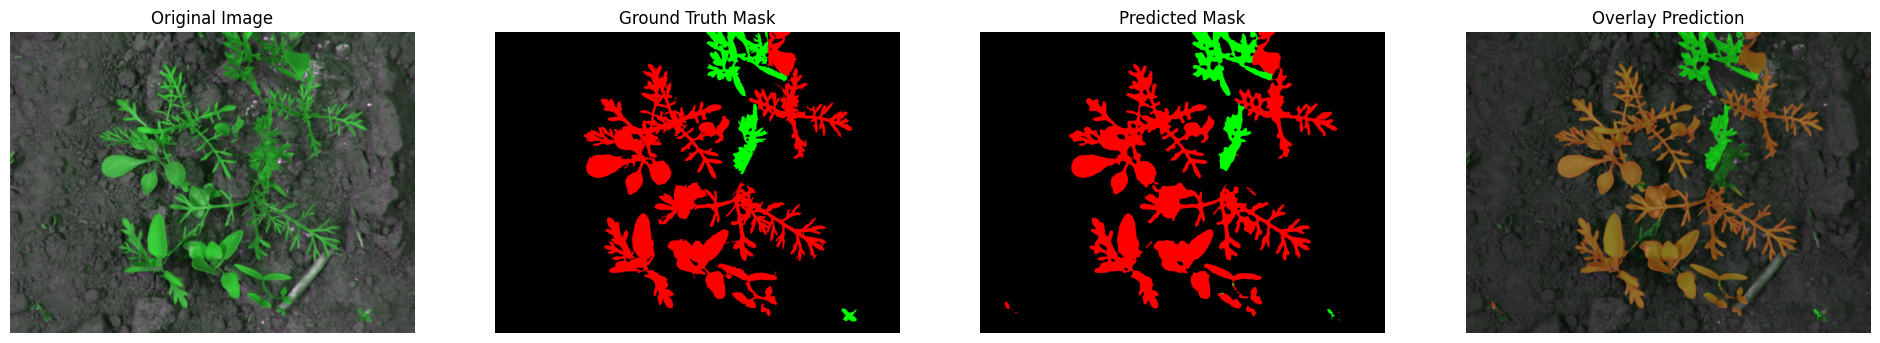

📊 Per-Class Evaluation Metrics:
Background | Precision: 0.9856, Recall: 0.9888, F1: 0.9872, IoU: 0.9747
Crop | Precision: 0.9161, Recall: 0.8866, F1: 0.9011, IoU: 0.8200
Weed | Precision: 0.9415, Recall: 0.9281, F1: 0.9348, IoU: 0.8775


In [71]:
image_path = '/content/dataset-1.0/images/001_image.png'
gt_mask_path = '/content/dataset-1.0/annotations/001_annotation.png'

# Load ground truth mask
gt_mask_rgb = Image.open(gt_mask_path).convert("RGB")
gt_mask_np = np.array(gt_mask_rgb)

# Convert RGB mask ke label mask
gt_label_mask = convert_rgb_mask_to_label(gt_mask_np)

# Inference gambar
img_np, pred_mask = infer_full_image(
    image_path=image_path,
    model=student_model,
    patch_size=512,
    stride=256,
    num_classes=3
)

# Visualisasi + evaluasi
class_names = ['Background', 'Crop', 'Weed']

precision, recall, f1, iou, cm = visualize_full_prediction(
    img_np, pred_mask, gt_mask=gt_label_mask, class_names=class_names
)


In [72]:
import random
import os
from PIL import Image
import numpy as np

# Path dataset
image_dir = '/content/dataset-1.0/images/'
gt_mask_dir = '/content/dataset-1.0/annotations/'

# Ambil semua file di folder gambar (filter png)
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

# Random sampling 5 file
random_images = random.sample(image_files, 5)

# Class names buat evaluasi
class_names = ['Background', 'Crop', 'Weed']

# Loop 5 sample
for idx, img_file in enumerate(random_images):
    print(f"\n🔎 Sample {idx+1}: {img_file}")

    # Path image dan ground truth mask
    image_path = os.path.join(image_dir, img_file)

    # Sesuaikan nama mask (replace image jadi annotation kalau beda)
    gt_mask_file = img_file.replace('image', 'annotation')  # <== Penyesuaian!
    gt_mask_path = os.path.join(gt_mask_dir, gt_mask_file)

    # Load ground truth mask
    gt_mask_rgb = Image.open(gt_mask_path).convert("RGB")
    gt_mask_np = np.array(gt_mask_rgb)

    # Convert RGB mask ke label mask
    gt_label_mask = convert_rgb_mask_to_label(gt_mask_np)

    # Inference gambar
    img_np, pred_mask = infer_full_image(
        image_path=image_path,
        model=student_model,
        patch_size=512,
        stride=256,
        num_classes=3
    )

    # Visualisasi + evaluasi
    precision, recall, f1, iou, cm = visualize_full_prediction(
        img_np, pred_mask, gt_mask=gt_label_mask, class_names=class_names
    )

    # Optional: print metrics simple
    print(f"✅ Finished sample {idx+1}")


Output hidden; open in https://colab.research.google.com to view.

#test pada test dataset

In [73]:
def infer_from_array(image_array, model, patch_size=512, stride=256, num_classes=3):
    # Convert array (H, W, C) ➡️ Tensor dan normalisasi (sama kayak training!)
    img_norm = (image_array / 255.0 - 0.5) / 0.5
    img_norm = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).float().cuda()  # B, C, H, W

    _, _, H, W = img_norm.shape

    # Prepare empty prediction mask
    pred_mask = torch.zeros((num_classes, H, W)).cuda()
    count_mask = torch.zeros((1, H, W)).cuda()

    # Hitung langkah patch
    y_steps = list(range(0, H - patch_size + 1, stride))
    x_steps = list(range(0, W - patch_size + 1, stride))

    if y_steps[-1] + patch_size < H:
        y_steps.append(H - patch_size)
    if x_steps[-1] + patch_size < W:
        x_steps.append(W - patch_size)

    # Sliding window inference
    for y in y_steps:
        for x in x_steps:
            patch = img_norm[:, :, y:y+patch_size, x:x+patch_size]

            with torch.amp.autocast('cuda'):
                output_raw = model(patch)
                # Unpack output utama kalo return tuple/list
                output = output_raw[0] if isinstance(output_raw, (tuple, list)) else output_raw

            pred_mask[:, y:y+patch_size, x:x+patch_size] += output.squeeze(0)
            count_mask[:, y:y+patch_size, x:x+patch_size] += 1

    # Normalisasi hasil prediksi
    pred_mask /= count_mask
    final_pred = torch.argmax(pred_mask, dim=0).cpu().numpy()

    return final_pred


In [74]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Asumsi test_dataset return: image, label_mask
# Kalau custom dataset lo return tuple lain ➡️ sesuaikan ya bro!

# Class names buat evaluasi
class_names = ['Background', 'Crop', 'Weed']

# Ambil 5 index random dari test_dataset
random_indices = random.sample(range(len(test_dataset)), 5)

for idx, sample_idx in enumerate(random_indices):
    print(f"\n🔎 Test Sample {idx+1} | Dataset index: {sample_idx}")

    # Ambil data sample dari test_dataset
    image_tensor, gt_label_mask = test_dataset[sample_idx]

    # Convert image_tensor (C, H, W) ➡️ numpy (H, W, C)
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()

    # Denormalisasi image kalau sebelumnya dinormalisasi
    img_np = (img_np * 0.5 + 0.5) * 255  # Sesuai normalisasi training lo!
    img_np = img_np.astype(np.uint8)

    # Inference ➡️ langsung dari image_tensor atau dari img_np
    # Kalau infer_full_image butuh path ➡️ kita bikin versi infer_from_array!
    pred_mask = infer_from_array(
        image_array=img_np,
        model=student_model,
        patch_size=512,
        stride=256,
        num_classes=3
    )

    # Visualisasi + evaluasi
    precision, recall, f1, iou, cm = visualize_full_prediction(
        img_np, pred_mask, gt_mask=gt_label_mask.cpu().numpy(), class_names=class_names
    )

    print(f"✅ Finished test sample {idx+1}")


Output hidden; open in https://colab.research.google.com to view.

In [75]:
import time
import torch

def measure_inference_time(model, input_size=(1, 3, 512, 512), num_runs=100, device='cuda'):
    model.eval()
    dummy_input = torch.randn(input_size).to(device)

    # Warm-up GPU (biar gak kena cold start)
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # Start timing
    torch.cuda.synchronize()  # pastikan semua proses selesai (untuk GPU)
    start_time = time.time()

    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(dummy_input)

    torch.cuda.synchronize()
    end_time = time.time()

    total_time = end_time - start_time
    avg_time_per_run = total_time / num_runs

    print(f"🔥 Inference time per image ({input_size[-2]}x{input_size[-1]}): {avg_time_per_run*1000:.2f} ms")
    print(f"⚡ FPS (Frames Per Second): {1.0 / avg_time_per_run:.2f}")

    return avg_time_per_run


In [76]:
import torch

if torch.cuda.is_available():
    gpu_idx = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(gpu_idx)
    gpu_capability = torch.cuda.get_device_capability(gpu_idx)
    gpu_mem = torch.cuda.get_device_properties(gpu_idx).total_memory / 1024**3

    print(f"🖥️ GPU Name         : {gpu_name}")
    print(f"🛠️ Compute Capability : {gpu_capability}")
    print(f"💾 Total VRAM        : {gpu_mem:.2f} GB")
else:
    print("⚠️ CUDA not available. Using CPU.")


🖥️ GPU Name         : Tesla T4
🛠️ Compute Capability : (7, 5)
💾 Total VRAM        : 14.74 GB


In [77]:
!nvidia-smi


Wed May 14 14:41:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             32W /   70W |    1890MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [78]:
# Pastikan model di GPU/CPU
student_model.cuda()  # atau model.cpu() kalau mau test CPU

# Ukur waktu inferensi, contoh input 512x512, 100 kali loop
measure_inference_time(student_model, input_size=(1, 3, 512, 512), num_runs=100, device='cuda')


🔥 Inference time per image (512x512): 5.34 ms
⚡ FPS (Frames Per Second): 187.14


0.00534367561340332

In [79]:
import time

start_time = time.time()

img_np, pred_mask = infer_full_image(
    image_path=image_path,
    model=student_model,
    patch_size=512,
    stride=256,
    num_classes=3
)

end_time = time.time()
total_time = end_time - start_time

print(f"🔥 Inference time per full image: {total_time:.3f} sec")
print(f"⚡ FPS (full image): {1.0 / total_time:.2f}")


🔥 Inference time per full image: 0.220 sec
⚡ FPS (full image): 4.55


#Evaluasi Head-to-Head Style McCool

In [80]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def evaluate_mccool_metrics(pred_mask, gt_mask, num_classes=3, class_names=None):
    # Flatten buat metric calculation
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    # Confusion Matrix
    cm = confusion_matrix(gt_flat, pred_flat, labels=list(range(num_classes)))

    # Overall Pixel-wise Accuracy
    overall_acc = np.sum(np.diag(cm)) / np.sum(cm)

    # Per-class Precision & Recall
    precision = precision_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)
    recall = recall_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)

    # FPR & FNR per class
    fpr = []
    fnr = []
    for cls in range(num_classes):
        tp = cm[cls, cls]
        fn = cm[cls, :].sum() - tp
        fp = cm[:, cls].sum() - tp
        tn = np.sum(cm) - (tp + fp + fn)

        fpr_cls = fp / (fp + tn + 1e-7)
        fnr_cls = fn / (fn + tp + 1e-7)

        fpr.append(fpr_cls)
        fnr.append(fnr_cls)

    # Tampilkan Hasil
    print(f"======================== McCool Style Metrics ========================")
    print(f"Overall Pixel-wise Accuracy (ACC): {overall_acc:.4f}")

    for cls in range(num_classes):
        name = class_names[cls] if class_names else f"Class {cls}"
        print(f"\n📌 {name}")
        print(f"Precision: {precision[cls]:.4f}")
        print(f"Recall   : {recall[cls]:.4f}")
        print(f"FPR      : {fpr[cls]*100:.2f}%")
        print(f"FNR      : {fnr[cls]*100:.2f}%")

    return overall_acc, precision, recall, fpr, fnr


In [81]:
def evaluate_dataset_mccool(model, loader, dataset_name='Dataset', class_names=None, num_classes=3):
    model.eval()

    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.cuda()
            masks = masks.cuda()

            with torch.amp.autocast('cuda'):
                outputs_raw = model(imgs)

                # Cek output
                outputs = outputs_raw[0] if isinstance(outputs_raw, (tuple, list)) else outputs_raw

            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy().flatten())
            all_masks.append(masks.cpu().numpy().flatten())

    # Gabungkan semua prediksi dan ground truth
    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)

    print(f"\n====================== {dataset_name} ======================")
    return evaluate_mccool_metrics(all_preds, all_masks, num_classes=num_classes, class_names=class_names)


In [82]:
# Pastikan class_names sesuai dataset
class_names = ['Background', 'Crop', 'Weed']

# Train
evaluate_dataset_mccool(student_model, train_loader, dataset_name='TRAIN', class_names=class_names)

# Validation
evaluate_dataset_mccool(student_model, val_loader, dataset_name='VALIDATION', class_names=class_names)

# Test
evaluate_dataset_mccool(student_model, test_loader, dataset_name='TEST', class_names=class_names)



====================== TRAIN ======================
======================== McCool Style Metrics ========================
Overall Pixel-wise Accuracy (ACC): 0.9882

📌 Background
Precision: 0.9930
Recall   : 0.9945
FPR      : 7.34%
FNR      : 0.55%

📌 Crop
Precision: 0.9179
Recall   : 0.9069
FPR      : 0.17%
FNR      : 9.31%

📌 Weed
Precision: 0.9433
Recall   : 0.9263
FPR      : 0.40%
FNR      : 7.37%

====================== VALIDATION ======================
======================== McCool Style Metrics ========================
Overall Pixel-wise Accuracy (ACC): 0.9841

📌 Background
Precision: 0.9925
Recall   : 0.9922
FPR      : 8.57%
FNR      : 0.78%

📌 Crop
Precision: 0.8749
Recall   : 0.8113
FPR      : 0.21%
FNR      : 18.87%

📌 Weed
Precision: 0.8912
Recall   : 0.9134
FPR      : 0.74%
FNR      : 8.66%

====================== TEST ======================
======================== McCool Style Metrics ========================
Overall Pixel-wise Accuracy (ACC): 0.9847

📌 Background
Pre

(np.float64(0.9847055276234945),
 array([0.99143371, 0.90020095, 0.92870675]),
 array([0.99372776, 0.85729494, 0.91730392]),
 [np.float64(0.07844716819255901),
  np.float64(0.0024079208617863008),
  np.float64(0.005622751069064127)],
 [np.float64(0.006272237337221512),
  np.float64(0.14270505670373715),
  np.float64(0.08269608385790213)])

#tes langsung 512x512 tanpa patch

 Random ➡️ Resize ➡️ Inference ➡️ Visualisasi

In [83]:
import random
import os
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

# Path dataset asli
image_dir = '/content/dataset-1.0/images/'
gt_mask_dir = '/content/dataset-1.0/annotations/'

# Ambil semua file gambar
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

# Ambil 5 gambar random
random_images = random.sample(image_files, 5)

# Class names buat evaluasi
class_names = ['Background', 'Crop', 'Weed']

# Model ke eval mode
student_model.eval()

for idx, img_file in enumerate(random_images):
    print(f"\n🔎 Sample {idx+1}: {img_file}")

    # Load image
    image_path = os.path.join(image_dir, img_file)
    img = Image.open(image_path).convert("RGB")

    # Resize ke 512x512
    img_resized = img.resize((512, 512))
    img_np = np.array(img_resized)

    # Normalisasi (sesuai training transform lo)
    img_norm = (img_np / 255.0 - 0.5) / 0.5
    img_tensor = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).float().cuda()  # [1, C, 512, 512]

    # Ground truth mask
    gt_mask_file = img_file.replace('image', 'annotation')  # Pastikan sesuai nama mask lo!
    gt_mask_path = os.path.join(gt_mask_dir, gt_mask_file)
    gt_mask = Image.open(gt_mask_path).convert("RGB")
    gt_mask_resized = gt_mask.resize((512, 512))  # Resize mask juga!
    gt_mask_np = np.array(gt_mask_resized)

    # Convert RGB mask ke label mask
    gt_label_mask = convert_rgb_mask_to_label(gt_mask_np)

    # Inference
    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            outputs_raw = student_model(img_tensor)
            outputs = outputs_raw[0] if isinstance(outputs_raw, (tuple, list)) else outputs_raw

    # Ambil prediksi mask
    pred_mask = torch.argmax(outputs.squeeze(0), dim=0).cpu().numpy()

    # Convert image_tensor buat visualisasi
    img_vis = (img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255
    img_vis = img_vis.astype(np.uint8)

    # Visualisasi + evaluasi
    precision, recall, f1, iou, cm = visualize_full_prediction(
        img_vis, pred_mask, gt_mask=gt_label_mask, class_names=class_names
    )

    print(f"✅ Finished sample {idx+1}")


Output hidden; open in https://colab.research.google.com to view.